In [1]:
import pandas as pd
import numpy as np
import heapq # Let's use the heapq module for the priority queue of the different algorithms
from collections import deque # deque is used to implement the queue to store the visited nodes
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import math
from joblib import Parallel, delayed
import multiprocessing

# Class and functions

In this part we will implement the classes describing the biscuits and the roll.

As told in the problem description the biscuits have 3 attributes: 

- length
- value
- admissible defects

The length and value are both integer values and we decide to represent the admissible defects as a dictionnary of string and int. The string represents the defect name and the integer value represents the amount of defect admissible.

In [2]:
class Biscuit:
    def __init__(self, id:int,length:int, value:int, admissible_defects:dict[str:int]):
        """
        length: length of the biscuit
        value: value of the biscuit
        admissible_defects: dictionary of admissible defects with the maximum number of defects for each type
        """
        self.id = id
        self.length = length
        self.value = value
        self.admissible_defects = admissible_defects

    def __str__(self):
        return f"Biscuit(length={self.length}, value={self.value}, admissible_defects={self.admissible_defects})"

The roll is composed of two attributes: 

- length
- defects

The length of the roll is an integer representing its length and the defects are represented by a dictionnary containing the positions of each class of defects.

The Roll class has several functions allowing the placement of a biscuit or not, getting the value of the roll etc. 

In [3]:
class Roll:
    def __init__(self, length:int, defects:dict[float,str]):
        """
        :param: length: the length of the roll\n
        :param: defects: a dictionary of defects, key is the position of the defect, value is the type of the defect
        """
        self.length = length
        self.defects = defects
        self.biscuits = {} # biscuits: {pos: Biscuit}
        self.available_pos = set(range(0, length))
    
    def TestPosBiscuit(self, pos:int, biscuit:Biscuit)-> bool:
        """
        Test if a biscuit can be placed at a given position\n
        :param: pos: the position where the biscuit is placed
        :param: biscuit: the biscuit to be placed
        :return: True if the biscuit can be placed, False otherwise\n
        """
        unique_defects = set(self.defects.values())
        portion_defects = {val:0 for val in unique_defects}

        pos_def = [i for i in self.defects.keys() if pos <= i < pos+biscuit.length]
        if not(set(range(pos, pos+biscuit.length)).issubset(self.available_pos)):
            return False

        for i in pos_def:
            portion_defects[self.defects[i]] += 1
            
        for key in portion_defects.keys():
            if portion_defects[key] > biscuit.admissible_defects[key]:
                return False
            
        return True

    def GetState(self)-> np.array:
        """
        Get the state of the roll\n
        :return: the state of the roll\n
        """
        state = np.ones(self.length)*-1
        positions = list(self.biscuits.keys())
        positions.sort()
        for i in range(len(positions)):
            state[positions[i]:positions[i]+self.biscuits[positions[i]].length] = self.biscuits[positions[i]].id
        return state
    
    def PlaceBiscuit(self, pos:int, biscuit:Biscuit)-> bool:
        """
        Place a biscuit at a given position\n
        :param: pos: the position where the biscuit is placed
        :param: biscuit: the biscuit to be placed\n
        """
        if self.TestPosBiscuit(pos, biscuit):      
            for i in range(pos, pos+biscuit.length):
                self.available_pos.remove(i)
            
            self.biscuits[pos] = biscuit
            return True
        return False

    def GetValue(self)-> tuple[int,int]: 
        """
        Get the value and the penalty of the roll\n
        :return: the value and the penalty of the roll\n
        """
        value = 0
        for key in self.biscuits.keys():
            value += self.biscuits[key].value
        
        penalty = len(self.available_pos)
        return value, penalty
    
    def GetExcessDefects(self, pos:int, biscuit:Biscuit)-> dict[str,int]:
        excess = {}
        unique_defects = set(self.defects.values())
        portion_defects = {val:0 for val in unique_defects}

        pos_def = [i for i in self.defects.keys() if pos <= i < pos+biscuit.length]
        if not(set(range(pos, pos+biscuit.length)).issubset(self.available_pos)):
            return excess

        for i in pos_def:
            portion_defects[self.defects[i]] += 1
            
        for key in portion_defects.keys():
            if portion_defects[key] > biscuit.admissible_defects[key]:
                excess[key] = portion_defects[key] - biscuit.admissible_defects[key]
            
        return excess

    
    
    def __lt__(self, other):
        return self.GetValue()[0]-self.GetValue()[1] < other.GetValue()[0]-other.GetValue()[1]
    
    def __eq__(self, value: object) -> bool:
        return self.biscuits == value.biscuits
    
    def __ge__(self, other):
        return self.GetValue()[0]-self.GetValue()[1] >= other.GetValue()[0]-other.GetValue()[1]
    
    def __le__(self, other):
        return self.GetValue()[0]-self.GetValue()[1] <= other.GetValue()[0]-other.GetValue()[1]
    
    def __hash__(self):
        return hash(tuple(self.biscuits.items()))

The following functions have been added along the project to solve different problem. 

**PossibleState**: Generate the possible states from a given state. This means the function returns all the possible roll who are one biscuit away without replacement from the current one. This is useful in almost every method we want to implement. For example for the greedy algorithm to know the available state.

**FindCollision**: Find the biscuits that collide with a given biscuit at a given position. This means the function returns a list of biscuit that collide with the given one. Getting a list of the biscuits in conflict with a given one is very useful to remove them to place the wanted one for example which is useful for the mutations in the genetic algorithm for example. 

**CountCollision**: In the same idea of the precedent one this function is useful to detects overlapping but this time the function returns the amount of position involve in a conflict. Like the precedent one knowing the amount of position in conflicts allows an agent to understand better the size of the biscuits and the rules to place a biscuit when using reinforcement learning.

In [4]:
def PossibleState(roll:Roll, biscuits:list[Biscuit])-> set[Roll]:
    """
    Generate all possible states from a given state\n
    :param: roll: the current roll\n
    :param: biscuits: the list of biscuits\n
    :return: a set of possible states\n
    """
    possible_states = set()
    for pos in roll.available_pos:
        for biscuit in biscuits:
            new_roll = Roll(roll.length, roll.defects)
            new_roll.biscuits = roll.biscuits.copy()
            new_roll.available_pos = roll.available_pos.copy()
            if new_roll.PlaceBiscuit(pos, biscuit):
                possible_states.add(new_roll)
                

    return possible_states

In [5]:
def FindCollision(roll:Roll, biscuit:Biscuit, pos:int)-> list[int]:
    """
    Find the biscuits that collide with a given biscuit\n
    :param: roll: the roll\n
    :param: biscuit: the biscuit\n
    :param: pos: the position of the biscuit\n
    :return: the list of biscuits that collide with the given biscuit\n
    """

    collisions = []
    for key in roll.biscuits.keys():
        if pos <= key < pos+biscuit.length or key <= pos < key+roll.biscuits[key].length:
            collisions.append(key)
    return collisions 

def CountCollision(roll:Roll, biscuit:Biscuit, pos:int)-> int:
    """
    Find the biscuits that collide with a given biscuit\n
    :param: roll: the roll\n
    :param: biscuit: the biscuit\n
    :param: pos: the position of the biscuit\n
    :return: the amount of collision found (if the biscuit overlap 3 spaces on one biscuit it will return 3)\n
    """
    
    collisions = 0
    for key in roll.biscuits.keys():
        if pos <= key < pos+biscuit.length or key <= pos < key+roll.biscuits[key].length:
            pos_used = {i for i in range(key, key+roll.biscuits[key].length, 1)}
            pos_wanted = {i for i in range(pos, pos+biscuit.length, 1)}
            collisions += len(pos_used & pos_wanted)

    return collisions 


def FindSubset(set:set,length_subset:int = 2):
    """
    Find all the subsets of a given set of length length_subset\n
    :param: set: the set\n
    :param: length_subset: the length of the subsets\n
    :return: the subsets\n
    """
    if length_subset == 0:
        return [set()]
    if length_subset == 1:
        return [{i} for i in set]
    subsets = []
    for i in set:
        new_set = set.copy()
        new_set.remove(i)
        for subset in FindSubset(new_set, length_subset-1):
            subset.add(i)
            subsets.append(subset)
            
    return subsets

def DropDuplicates(subsets:list)-> list:
    """
    Drop duplicates from a list of subsets\n
    :param: subsets: the list of subsets\n
    :return: the list of subsets without duplicates\n
    """
    to_ret = []
    for subset in subsets:
        if subset not in to_ret:
            to_ret.append(subset)
    return to_ret


def OutOfBounds(biscuit:Biscuit, pos:int):
    """
    Check if a biscuit is out of bounds\n
    :param: biscuit: the biscuit\n
    :param: pos: the position of the biscuit\n
    :return: the amount of space the biscuit is out of bounds\n
    """
    pos_max = pos+biscuit.length
    if pos_max > 500:
        return pos_max - 500
    return 0

In [6]:
def visualize(roll:Roll)-> str:
    """
    Visualize the roll\n
    :param: roll: the roll to be visualized\n
    """
    roll_str = ""
    i = 0
    while i < roll.length:
        if i in roll.biscuits.keys():
            biscuit_length = roll.biscuits[i].length
            for j in range(biscuit_length):
                if biscuit_length == 4:
                    roll_str += "0 "
                elif biscuit_length == 8:
                    roll_str += "1 "
                elif biscuit_length == 2:
                    roll_str += "2 "
                elif biscuit_length == 5:
                    roll_str += "3 "
                i += 1
            roll_str += "| "
        else:
            roll_str += "-- "
            i += 1
            
    return roll_str


# Initialisation

In [7]:
biscuit0 = Biscuit(0, 4, 3, {'a':4, 'b':2, 'c':3})
biscuit1 = Biscuit(1, 8, 12, {'a':5, 'b':4, 'c':4})
biscuit2 = Biscuit(2, 2, 1, {'a':1, 'b':2, 'c':1})
biscuit3 = Biscuit(3, 5, 8, {'a':2, 'b':3, 'c':2})

In [8]:
df_defects = pd.read_csv('defects.csv')
print(df_defects.nunique())
print(len(df_defects))

x        500
class      3
dtype: int64
500


We can see there is no defect at the same position, so we can construct the dictionnary of defects as follow:

In [9]:
defects = df_defects.to_dict(orient='records')
defects = {i['x']:i['class'] for i in defects}

In [10]:
roll = Roll(500, defects)

# Naive Approaches - Greedy Algorithms

We first implement different naive approaches/greedy algorithms to apprehend the problem. 

**Greedy1**: Greedy1 is the first naive approach implemented. The heuristic behind this algorithm is to always choose the next state with the highest value. This is why we use a heapq to always have the states sorted. (We use the value of the roll $\times(-1)$ to place in the heapq because the values are sorted in ascending order)

**Greedy2**: Greedy2 is the second approaches we try which offers better results than the first one. This time the algorithm tries to place the best biscuit (in term of ratio value/length) at successive positions; 

it tries to place the best at the first position, 

if possible the biscuit is placed

else tries to place the second best etc. and if there is no biscuit which can be placed it repeats the process at the next position.

In [11]:
def Greedy1(start: Roll, biscuits: list[Biscuit],verbose:bool = False, stop_ite:int = 100000):
    """    
    Greedy algorithm\n
    Choose the best first possible state at each iteration\n
    :param: start: the starting roll\n
    :param: biscuits: the list of biscuits\n
    :param: verbose: boolean to print the progress\n
    :param: stop_ite: the maximum number of iterations\n
    :return: the final roll\n
    """
    node_list = [(0,start)]
    heapq.heapify(node_list)
    visited = deque()
    visited_set = {start}
    l_set = 0
    iteration = 0
    while node_list:
        cost, node = heapq.heappop(node_list)
        visited.append(node)

        if verbose:
            print(f"\rAmount of placed biscuits : {len(node.biscuits)}, Current value of the roll : {node.GetValue()[0] - node.GetValue()[1]}, Amount of node in the frontier : {len(node_list)}, Iteration : {iteration}", end = '')
            #print(node.biscuits)
            
        pos_states = PossibleState(node, biscuits)
        if pos_states == set():
            return node, visited, iteration
        
        for state in pos_states:
            visited_set.add(state)
            if len(visited_set) > l_set:
                l_set += 1
                heapq.heappush(node_list, (-(state.GetValue()[0] - state.GetValue()[1]),state))

        iteration += 1
        if iteration == stop_ite:
            return None, visited, node_list

    return None, visited, node_list
        

In [12]:
best = Greedy1(roll, [biscuit0, biscuit1, biscuit2, biscuit3], verbose=True, stop_ite=1000000)

Amount of placed biscuits : 72, Current value of the roll : 586, Amount of node in the frontier : 32031, Iteration : 720

In [13]:
def Greedy2(start: Roll, biscuits: list[Biscuit],verbose:bool = False, stop_ite:int = 100000):
    """   
    Greedy algorithm\n
    Place the biscuit with the highest ratio value/length first\n
    :param: start: the starting roll\n
    :param: biscuits: the list of biscuits\n
    :param: verbose: boolean to print the progress\n
    :param: stop_ite: the maximum number of iterations\n
    :return: the final roll\n
    """
    biscs = ([biscuit.value/biscuit.length for biscuit in biscuits])
    biscs_ordered = [biscuits[i] for i in np.argsort(biscs)[::-1]]
    current_roll = start
    for pos in range(start.length):
        for bisc in biscs_ordered:
            current_roll.PlaceBiscuit(pos, bisc)
                

    return current_roll

In [14]:
test = Greedy2(roll, [biscuit0, biscuit1, biscuit2, biscuit3])

In [15]:
test.GetValue()

(690, 15)

## Conclusion

We can see here that the second algorithm offers better results than the first one and is faster. Even if the two algorithms are fast, the second algorithm takes less than 1 second and the first one takes about 3 seconds.
This is because the second one does not allow lots of empty space between two biscuits that the first one did not do well. Moreover, the second algorithm is guided by the ration value/length of the biscuits which can help it getting better results. 

# Genetic Algorithm

The first more advanced algorithm we implemented was the Genetic algorithm. 

To apply a genetic algorithm on our problem we did the following: 

Each individual is a roll. To create our initial population we choose $n$ rolls with 1 biscuit placed at a random postition. Now that we have an initial population we upgrade the population by applying the greedy algorithms presented earlier. Doing this creates a population with good elements because all the rolls are entirely filled but with diversity because they do not start at the same position. 

However, after some tests we found that even with this method the diversity was still not important enough. To adress this problem we add mutations to the precedent initial rolls; we use the Mutation method of the genetic algorithm to get more diversity in our initial population to avoid getting stuck in local maximum. So, we perform a certain amount of mutation randomly and we choose randomly a certain amount of the created rolls. Adding diversity this way has the benefits to accelerate the process of creating an initial population as well as adding more diversity in the initial population.

Now that we have an initial population we can start applying the algorithm. The first step is to select some individuals to perform crossover on them. This will create some new individual with characteristics of the parents. After that, we apply mutation on children to create diversity that can lead to improvements of the solution. Finally, a new population is created by replacing the weakest parents by the created children. 

Here, we've decided to keep our population stable (population with the same number of rolls) to prevent the population from increasing too much, which would also increase calculation costs, or conversely, to prevent the population from decreasing and creating a lack of diversity.

We will develop each steps of the algorithm later.

In [16]:
roll = Roll(500, defects)

## Implementation


Let's define the fitness function. 
We want the highest possible value so let's try to maximize the value of a roll. 

In [16]:
def fitness_function(roll:Roll)-> int:
    """"
    Fitness function\n
    :param: roll: the roll\n
    :return: the fitness of the roll\n
    """
    return roll.GetValue()[0] - roll.GetValue()[1]

### **<u>Selection</u>**


We created different selection function: 

- The Roulette Wheel Selection with Elitism
- Tournament Selection

**Roulette Wheel Selection**: 

Roulette selection assigns fitness to each individual in the population. They are allocated space on the wheel in proportion of their fitness. This idea is represented by a list where an individual will appear 2 times more than an other one if it is two times more fitted for example. Now that we have our wheel ready we can spin it a certain amount of time. e.g: we select a certain amount of individual. This method increases the chance of selecting good elements by still giving a chance to weaker one to be selected with a non-zero probability. 
We created two types of wheel. One which allow spaces according to the proportion of the fitness of an individual over the total fitness and an other one which uses the softmax function to enhance selection pressure, handling negative fitness value and helping balance diversity in solutions. This second way to create the wheel worked better during our tests.

**Tournament Selection**:

Randomly select a subset from the population and select the bests of each subset. This method works well with large populations and is easy to parametrized: 

- Small subset = more diversity (less pressure on elites).
- Large subset = more selective pressure (favors elites more strongly).

Moreover, tournament selection can be faster for large population and is not affected by fitness scaling.

In [ ]:
def CreateWheel(population:list[Roll], fitness_function)-> list[Roll]:
    """
    Create a wheel of fortune based on the fitness of the population\n
    :param: population: the population of the wheel\n
    :param: fitness_function: the fitness function\n
    :return: the wheel of fortune\n
    """
    fitness = [fitness_function(roll) for roll in population]
    total_fitness = sum(fitness)
    wheel = []
    for i in range(len(population)):
        wheel += [population[i]]*int((fitness[i]/total_fitness)*10000)
    return wheel

def CreateWheel_softmax(population:set[Roll], fitness_function)-> list[Roll]:
    """
    Create a wheel of fortune based on the fitness of the population using softmax\n
    :param: population: the population of the wheel\n
    :param: fitness_function: the fitness function\n
    :return: the wheel of fortune\n
    """
    fitness = [fitness_function(roll) for roll in population]
    wheel = []
    mean = np.mean(fitness)
    std = np.std(fitness)
    norm_fitness = [(i-mean)/std for i in fitness]
    for i in range(len(norm_fitness)):
        wheel += [population[i]]*int((np.exp(norm_fitness[i])/sum(np.exp(norm_fitness)))*10000)
    return wheel


def Wheel_Selection(wheel:list[Roll], n:int)-> list[Roll]:
    """
    Select n individuals from the wheel of fortune\n
    :param: wheel: the wheel of fortune\n
    :param: n: the number of individuals to select\n
    :return: the selected individuals\n
    """
    to_ret = set(random.sample(wheel, n))
    to_ret.add(max(wheel, key=lambda x: fitness_function(x)))
    while len(to_ret) < n:
        to_ret.add(random.choice(wheel))

    return list(to_ret)


def random_subsets(original_set:set, n:int)-> list[set]:
    """
    Generate n random subsets from a given set\n
    :param: original_set: the original set\n
    :param: n: the number of subsets to generate\n
    :return: the list of subsets\n
    """
    to_ret = []
    curr_set = original_set.copy()
    subset_length = len(original_set)//n
    for i in range(n):
        curr_set = set(random.sample(list(original_set), subset_length))
        to_ret.append(curr_set)
        original_set = original_set - curr_set # avoid duplicates

    return to_ret


def Tournament(population:set[Roll], k=1) -> Roll:
    """
    Select the best individual from the population\n
    :param: population: the population\n
    :param: k: the number of individuals to select\n
    :return: the selected individual\n
    """
    return max(list(population), key=lambda x: fitness_function(x))

def Tournament_Selection(population:set[Roll], n_subset:int, n_winner:int)-> list[Roll]:
    """"
    Select n_winner individuals from the population using tournament selection\n
    :param: population: the population\n
    :param: n_subset: the number of tounament to create\n
    :param: n_winner: the number of individuals to select for each tournament\n
    :return: the selected individuals\n
    """

    subsets = random_subsets(population, n_subset)
    winners = []
    for subset in subsets:
        winners.append(Tournament(subset, n_winner))

    return winners


### **<u>Crossover</u>**

Let's now implement the different Crossovers.

We implemented two different crossovers: 

- Random Crossover
- n-point Crossover

**Random crossover**: 

Initialize an empty roll, find the possible positions to place a biscuit, randomly add biscuits from the parents by selecting a random positition and biscuit from the valid positions and attempts to place the biscuit on the roll and finally updates the valid possibility to avoid overlapping. We repeat these step until no valid positions remain. 

This implementation randomly combines features from both parents, potentially discovering new, diverse configurations. Hence, is good to explore unexpected configurations and keep a good diversity. 

**n-point Crossover**:

Split the two parents into parts by selecting n random crossover points. Finally combines slices from the two parents alternatively based on the crossover points. 

Systematically mixes features from both parents, retaining structural patterns while introducing variation. Allows fine-grained control over which parent contributes more to certain regions of the solution. It can better preserve good substructures.

This method is good to balance exploration and exploitation by keeping good structures.

In [ ]:
def Crossover_random(parent1:Roll, parent2:Roll, possible_pos = [])-> Roll:
    """
    Perform a crossover between two parents\n
    :param: parent1: the first parent\n
    :param: parent2: the second parent\n
    :return: the child\n
    """
    child = Roll(parent1.length, parent1.defects)
    if possible_pos == []:
        possible_pos = PossibleState(child, [biscuit0, biscuit1, biscuit2, biscuit3])
        possible_pos = [list(i.biscuits.items()) for i in list(possible_pos)]
    
    possible_pos_set = set()

    for tab in possible_pos:
        for elem in tab:
            possible_pos_set.add(elem)
    

    items_parent1 = set(parent1.biscuits.items())
    items_parent2 = set(parent2.biscuits.items())
    items_child = set(child.biscuits.items())

    possible_pos = list(possible_pos_set & (items_parent1 | items_parent2) - items_child)
    
    while len(possible_pos) > 0:
        pos, biscuit = random.choice(possible_pos)
        if child.PlaceBiscuit(pos, biscuit):
            
            possible_pos = [(x,y) for x,y in possible_pos if x not in range(pos, pos+biscuit.length)]
        else:
            possible_pos.remove((pos, biscuit))

    return child
        
def multi_point_crossover(parent1: Roll, parent2: Roll, num_points: int) -> Roll:
    """
    Multi-point crossover between two parent Rolls.
   
    :param parent1: The first parent Roll
    :param parent2: The second parent Roll
    :param num_points: The number of crossover points
    :return: Two children Rolls
    """
    child1 = Roll(parent1.length, parent1.defects)
 
    # Convert biscuits to list to allow slicing
    parent1_biscuits = list(parent1.biscuits.items())
    parent2_biscuits = list(parent2.biscuits.items())
    
    start_bisc = list(set(list(parent1.biscuits.keys()) + list(parent2.biscuits.keys())))
    # Select random crossover points
    points = sorted(random.sample(start_bisc, num_points))
    bascule = True  # Determines which parent to take from
   
    # Create children by combining parts from each parent
    start = 0
    for point in points + [parent1.length]:
        if bascule:
            for pos in range(start, point):
                if pos in parent1.biscuits.keys():
                    child1.PlaceBiscuit(pos, parent1.biscuits[pos])
        else:
            for pos in range(start, point):
                if pos in parent2.biscuits.keys():
                    child1.PlaceBiscuit(pos, parent2.biscuits[pos])
        bascule = not bascule
        start = point
 
    return child1

### **<u>Mutation</u>**


The mutation randomly places a random biscuit at a random position (it selects only possible position according to the defects) by replacing the biscuit originally placed if needed.

In [17]:
def Mutation(roll:Roll, biscuits:list[Biscuit], initial_possible_pos = [])-> Roll:
    """
    Perform a mutation on a roll\n
    :param: roll: the roll to mutate\n
    :param: biscuits: the list of biscuits\n
    :return: the mutated roll\n
    """
    if initial_possible_pos == []:
        empty_roll = Roll(roll.length, roll.defects)
        possible_pos = PossibleState(empty_roll, biscuits)
        possible_pos = [list(i.biscuits.items()) for i in list(possible_pos)]
    else:
        possible_pos = initial_possible_pos

    new_roll = Roll(roll.length, roll.defects)
    new_roll.biscuits = roll.biscuits.copy()
    new_roll.available_pos = roll.available_pos.copy()
    pos, biscuit = random.choice(list(possible_pos))[0]
    
    possible = new_roll.PlaceBiscuit(pos, biscuit)
    if not possible:
        collision = FindCollision(new_roll, biscuit, pos)
        for key in collision:
            bisc = new_roll.biscuits[key]
            for i in range(key, key+bisc.length):
                new_roll.available_pos.add(i)
            del new_roll.biscuits[key]
        new_roll.PlaceBiscuit(pos, biscuit)

    return new_roll

### <u>Implementation of the genetic algorithm</u>


The following function gathers all the precedent part to perform the genetic algorithm. Each part are loop for a given number of iterations. The following function keeps track of some statistics to see how the population evolves. This is useful to know how to fine tune hyperparameters (number of individuals, number of iterations, selection method etc.).

At the end of the iterations the function returns the best roll found.

In [ ]:
def GeneticAlgorithm(population:set[Roll], fitness_function, n_individuals:int, n_mutation_max = 5, weights = [], n_offspring_max = 3, n_best_to_keep = 10, verbose:bool = False, stop_ite:int = 10, crossover_type = -1, selection_type = -1)-> Roll:
    """
    Perform a genetic algorithm\n
    :param: population: the initial population\n
    :param: fitness_function: the fitness function\n
    :param: n_individuals: the number of individuals to select\n
    :param: n_mutation_max: the maximum number of mutations of an offspring\n
    :param: weights: the weights of the mutations; probability each number of mutations append\n
    :param: n_offspring_max: the maximum number of offspring\n
    :param: n_best_to_keep: the number of best individuals to keep at each iteration (Elitism)\n
    :param: verbose: whether to print the results\n
    :param: stop_ite: the number of iterations\n
    :param: crossover_type: the type of crossover, -1 for a random crossover else crossover_type = n > 0 for a n-point crossover \n
    :param: selection_type: the type of selection, -1 for a wheel selection, n > 0 for a tournament selection with n tournaments created, the amount of winner per tournament will be calculated by this parameter --> lower it is more winner are selected\n
    :return: the best roll\n
    """

    initial_possible_pos = [list(i.biscuits.items()) for i in list(PossibleState(Roll(500, defects), [biscuit0, biscuit1, biscuit2, biscuit3]))]

    if crossover_type == -1:
        Crossover = Crossover_random
    elif crossover_type <= 0 or crossover_type%1 != 0:
        raise ValueError(f"{crossover_type}-point crossover is not possible")
    else:
        Crossover = multi_point_crossover

    n_couples = (len(population) - n_best_to_keep)// n_offspring_max
    n_winner = (n_couples*2)//selection_type


    means = []
    maxs = []
    mins = []

    for i in range(stop_ite):
        #print(len(population))
        if selection_type == -1: 
            wheel = CreateWheel_softmax(list(population), fitness_function)
            selected = Wheel_Selection(wheel, n_individuals)

        elif selection_type <= 0 or selection_type%1 != 0:
            raise ValueError(f"{selection_type} for selection type is not possible")
        
        else:


            selected = Tournament_Selection(set(population), selection_type, n_winner)
        
        parents_possible = DropDuplicates(FindSubset(set(selected), 2))

        if len(parents_possible) < n_couples:
            raise ValueError("Not enough parents possible, increase the number of individuals to select")
        
        parents = random.choices(parents_possible, k=n_couples)

        children = []

        for parent in parents:
            for j in range(n_offspring_max):
                par = list(parent)
                if crossover_type == -1:
                    children.append(Crossover(par[0], par[1], possible_pos=initial_possible_pos))
                else:
                    children.append(Crossover(par[0], par[1], crossover_type))
                
        children_ = []
        for child in children:
            n_mutation = random.choices(range(n_mutation_max), weights = weights)[0]
            for j in range(n_mutation):
                child = Mutation(child, [biscuit0, biscuit1, biscuit2, biscuit3], initial_possible_pos)
            children_.append(child)
        
        children = children_

        list_pop = list(population)
        list_pop.sort(key = lambda x: fitness_function(x), reverse=True)
        
        population = children + list_pop[:len(population) - len(children)]


        if verbose:
            print("\r" + "\t"*500, end = '')
            print(f"\rIteration : {i}/{stop_ite}, best score : {max(population).GetValue()[0] - max(population).GetValue()[1]}, min score : {min(population, key=fitness_function).GetValue()[0] - min(population, key=fitness_function).GetValue()[1]}, mean score : {np.round(np.mean([fitness_function(roll) for roll in population]), 2)}, std score : {np.round(np.std([fitness_function(roll) for roll in population]),2)}, population length: {len(population)}, unique individuals: {len(set(population))}", end = '')
        
        means.append(np.mean([fitness_function(roll) for roll in population]))
        maxs.append(max(population).GetValue()[0] - max(population).GetValue()[1])
        mins.append(min(population, key=fitness_function).GetValue()[0] - min(population, key=fitness_function).GetValue()[1])
        
    return max(population, key=fitness_function), means, maxs, mins

Let's start by creating a population of 100 solutions. To do this we will generate the function which is inspired of the greedy search algorithm but we will introduce random by placing a biscuit on the roll randomly.


In [ ]:
starting_population = random.sample(list(PossibleState(roll, [biscuit0, biscuit1, biscuit2, biscuit3])), 49)
starting_population.append(Greedy2(roll, [biscuit0, biscuit1, biscuit2, biscuit3])) # Add the best greedy solution to the starting population

population = set()
for state in tqdm(starting_population):
    best_roll_greedy = Greedy2(state, [biscuit0, biscuit1, biscuit2, biscuit3], verbose=False, stop_ite=100000)
    population.add(best_roll_greedy)


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


We now have a population of good solutions, let's try to upgrade it to find best solutions.<br>
Let's introduce some randomness with the Mutations before giving it to the Genetic algorithm

In [ ]:
pop = list(population)
n_mutation = 45
initial_possible_pos = [list(i.biscuits.items()) for i in list(PossibleState(Roll(500, defects), [biscuit0, biscuit1, biscuit2, biscuit3]))]

for i in range(len(pop)):
    n = random.randint(0, n_mutation)
    curr_roll = pop[i]
    for j in range(n):
        curr_roll = Mutation(curr_roll, [biscuit0, biscuit1, biscuit2, biscuit3], initial_possible_pos)
        pop.append(curr_roll)

population = set(pop)

In [ ]:
population = set(random.sample(list(population), 500))

In [ ]:
for roll in population:
    print(visualize(roll))

-- -- -- -- 1 1 1 1 1 1 1 1 | -- -- -- -- 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 2 2 | 0 0 0 0 | 1 1 1 1 1 1 1 1 | 2 2 | 0 0 0 0 | 3 3 3 3 3 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 2 2 | -- -- -- 0 0 0 0 | 1 1 1 1 1 1 1 1 | -- 1 1 1 1 1 1 1 1 | 0 0 0 0 | -- 0 0 0 0 | -- -- -- 0 0 0 0 | 1 1 1 1 1 1 1 1 | -- -- -- -- 0 0 0 0 | -- 0 0 0 0 | 0 0 0 0 | -- -- -- 2 2 | 3 3 3 3 3 | -- -- 0 0 0 0 | -- 2 2 | -- 3 3 3 3 3 | 3 3 3 3 3 | 0 0 0 0 | 2 2 | -- -- 2 2 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | -- -- 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | -- -- -- -- 0 0 0 0 | -- -- -- -- -- -- -- 3 3 3 3 3 | 0 0 0 0 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | -- -- 3 3 3 3 3 | -- -- 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | -- 1 1 1 1 1 1 1 1 | -- -- -- -- -- -- -- 2 2 | 2 2 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | -- -- -- -- -- -- -- 2 2 | -- -- -- 0 0 0 0 | 0 0 0 0 | 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 3 3 3 3 3 | 1

In [ ]:
for roll in population:
    print(roll.GetValue()[0] - roll.GetValue()[1], end = ' ')

530 303 455 389 532 317 400 461 662 437 646 528 468 403 600 430 373 531 515 630 498 361 606 410 592 431 324 554 418 520 525 521 461 393 626 647 627 664 447 490 622 430 511 675 541 546 347 602 596 544 640 497 506 386 599 381 391 632 593 318 477 394 404 658 506 559 596 373 518 512 489 567 451 570 557 396 419 453 515 314 543 587 523 392 322 610 637 457 474 513 612 339 364 431 563 608 320 617 452 367 437 618 303 669 343 629 383 332 461 499 493 475 526 449 511 421 494 595 563 507 604 397 652 643 635 622 557 659 462 597 402 437 581 598 343 331 428 669 493 575 444 603 662 629 423 497 649 411 669 635 484 320 640 469 344 616 396 385 416 533 568 593 521 303 417 535 313 629 370 592 505 616 400 622 309 480 628 434 518 503 672 462 315 649 614 419 635 613 668 502 336 383 669 632 666 640 450 428 391 383 597 293 590 366 383 334 359 573 596 374 523 480 496 515 556 541 477 319 510 587 556 342 460 450 497 354 433 473 555 464 662 627 429 488 668 659 671 370 626 503 458 443 334 646 378 439 669 555 457 500 

We can see the scores of the given roll are very different what shows the diversity.
The objective of creating a population like is to have a lots of diversity at the beginning and some good elements also.

In [ ]:
best_roll, means, maxs, mins = GeneticAlgorithm(population, fitness_function, n_individuals=25, n_offspring_max=3, n_best_to_keep=10, n_mutation_max=15, weights = [0.5] + [0.5/14]*14, verbose=True, stop_ite=2000, selection_type=100, crossover_type=4)

Iteration : 1999/2000, best score : 708, min score : 468, mean score : 644.71, std score : 62.48, population length: 500, unique individuals: 464																																																																																																																																																																																																																																																																																																																																																																			

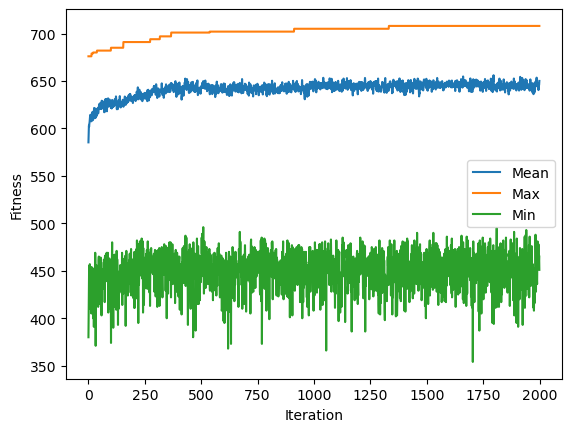

In [ ]:
plt.plot(means, label="Mean")
plt.plot(maxs, label="Max")
plt.plot(mins, label="Min")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()
plt.show()

As seen on this figure the minimum value of an individual remains low across iterations that means we have enough randomness to bring some new elements to the population. Moreover, we can see the mean increases but is still far from the maximum. It seems that we keep good diversity. 

We also can observe that the major improvements are made before the 500th iterations.

In [ ]:
visualize(best_roll) # best roll so far with a score of 708

'1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 2 2 | 0 0 0 0 | 1 1 1 1 1 1 1 1 | 2 2 | 0 0 0 0 | 3 3 3 3 3 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | -- -- 1 1 1 1 1 1 1 1 | 2 2 | 3 3 3 3 3 | -- 0 0 0 0 | 0 0 0 0 | 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 2 2 | 0 0 0 0 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | -- 1 1 1 1 1 1 1 1 | -- 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | -- -- 2 2 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 2 2 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 2 2 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 3 3 3 3 3 | 2 2 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 0 0 0 0 | 0 0 0 0 | 0 0 0 0 | 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 3 3 3 3 3 | 3 3 3 3 3 

In [ ]:
best_roll.GetValue() # best roll so far with a score of 708

(715, 7)

Second test of the genetic with Roulette wheel and random crossover with the same parameters.

In [ ]:
best_roll, means, maxs, mins = GeneticAlgorithm(population, fitness_function, n_individuals=25, n_offspring_max=3, n_best_to_keep=10, n_mutation_max=15, weights = [0.5] + [0.5/14]*14, verbose=True, stop_ite=2000, selection_type=-1, crossover_type=-1)

Iteration : 1999/2000, best score : 696, min score : 450, mean score : 628.98, std score : 60.25, population length: 500, unique individuals: 500																																																																																																																																																																																																																																																																																																																																																																			

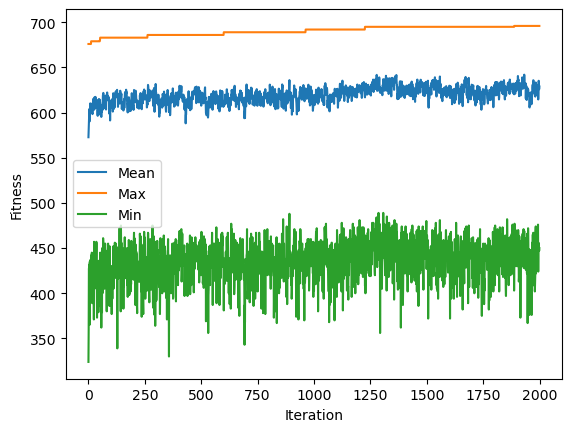

In [ ]:
plt.plot(means, label="Mean")
plt.plot(maxs, label="Max")
plt.plot(mins, label="Min")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()
plt.show()

## Conclusion

With the genetic algorithm the best score we found was 708 with 2000 iterations in roughly 90min. To achieve this performance we used 4 points cross over which is less random than the random cross over but still offers good exploratory performance. As selection techniques we used the tournament with 100 tournaments created. We had a starting population of 500 individuals, so a tournament regrouped 5 individuals. To control mutations we set the maximum amount of possible mutation at 15. The probability to get no mutation is 0.5 while the probabilities to get 1 to 15 mutations is $0.5/14$. Thanks to this we keep enough randomness for good exploration while ensuring exploitation with a high probability to not have any mutations. On top of that we keep the 10 best individuals at each iterations. 

The configuration with the 4 points crossover outperforms the configuration with roulette wheel and uniform crossover probably because the cutting the roll in only 5 parts allow to keep structures. As structure is important for this problem, this is probably the reason of the performance. For the selection function, tournament and roulette wheel are probably equivalent, the difference is that the tournaments are faster to compute and maybe this selection offers more diversity because if some bad elements are in the same tournament as worst element they can win. This can promote diversity. Moreover, as there are only 5 individuals per tournament, an element "just" has to be the best of 5 to be selected. Hence, diversity can be better with tournament for this reason.

We could maybe get better results with more iterations or with bigger populations. However, these changes will increase computational costs. 

# Local Search

The second type of more advanced algorithms we implemented was Local Search algorithms. 

We tried different algorithm: 

- Hill Climbing search 
- Stochastic Hill Climbing: 
    - Basic stochastic hill climbing
    - Simulated Annealing
    - Modified version of Simulated Annealing

To implement these algorithms we need new functions to define what is a neighbor state. We formalize a neighbor state as a roll which is one biscuit away from the current one but unlike the first part with the greedy algorithms we can replace a biscuit by an other. With this change a roll always have neighbors because it is always possible to place a biscuit. 


In [18]:
def fitness_function1(roll:Roll)-> int:
    """"
    Fitness function 1\n
    :param: roll: the roll\n
    :return: the value of the roll\n
    """
    return roll.GetValue()[0] - roll.GetValue()[1]

def fitness_function2(roll:Roll, obj:int = 715)-> float:
    """
    Fitness function 2\n
    value - penalty / objective --> to have a fitness score close to one as we approach the objective, make the fitness score approximately between -1 and 1\n
    :param: roll: the roll\n
    :param: obj: the objective\n
    :return: the fitness\n
    """
    return (roll.GetValue()[0] - roll.GetValue()[1])/obj


def NeighborsStates(roll:Roll, biscuits:list[Biscuit])-> set[Roll]:
    """
    Generate all neighbors states from a given state\n
    :param: roll: the current roll\n
    :param: biscuits: the list of biscuits\n
    :return: a set of neighbors states\n
    """
    neighbors = set()
    for pos in range(roll.length):
        for biscuit in biscuits:
            new_roll = Roll(roll.length, roll.defects)
            new_roll.biscuits = roll.biscuits.copy()
            new_roll.available_pos = roll.available_pos.copy()
            possible = new_roll.PlaceBiscuit(pos, biscuit)

            if not possible:
                collision = FindCollision(new_roll, biscuit, pos)
                for key in collision:
                    bisc = new_roll.biscuits[key]
                    for i in range(key, key+bisc.length):
                        new_roll.available_pos.add(i)
                    del new_roll.biscuits[key]
                new_roll.PlaceBiscuit(pos, biscuit)
    
            neighbors.add(new_roll)
            
    return neighbors


## Creating Initial population

In [81]:
roll = Roll(500, defects)

In [ ]:
starting_population = random.sample(list(PossibleState(roll, [biscuit0, biscuit1, biscuit2, biscuit3])), 10)

population = set()
for state in tqdm(starting_population):
    best_roll = Greedy2(state, [biscuit0, biscuit1, biscuit2, biscuit3], verbose=False, stop_ite=100000)
    population.add(best_roll)

pop = list(population)
n_mutation = 50


for i in tqdm(range(len(pop))):
    n = random.randint(0, n_mutation)
    curr_roll = pop[i]
    for j in range(n):
        curr_roll = Mutation(curr_roll, [biscuit0, biscuit1, biscuit2, biscuit3])
        pop.append(curr_roll)
pop = list(set(pop))


## Hill Climbing Search


This algorithm continuously moves to the best successor of the current node according to an objective function. However, as expected it fell quicky in local optimums the maximum we found was 688 using random-restart with 214 different starting positions.  

In [19]:
def HillClimbing(roll:Roll, biscuits:list[Biscuit], verbose:bool = False, stop_ite:int = 10)-> Roll:
    """
    Perform a hill climbing algorithm\n
    :param: roll: the initial roll\n
    :param: biscuits: the list of biscuits\n
    :param: verbose: whether to print the results\n
    :param: stop_ite: the number of iterations\n
    :return: the best roll\n
    """
    
    current = roll
    best = roll
    bests = []
    amelio = []
    visited = set()
    visited.add(current)

    for i in range(stop_ite):
        neighbors = NeighborsStates(current, biscuits)
        best_neighbor = np.max(list(neighbors))
        visited.add(best_neighbor)
        if best_neighbor > current:
            current = best_neighbor
        
        if current > best:
            best = current
        else:
            break
        if verbose:
            print(f"\r"+" "*200, end = "")
            print(f"\rIteration : {i}, current score : {current.GetValue()[0] - current.GetValue()[1]}, best score : {best.GetValue()[0] - best.GetValue()[1]}", end = '')

        amelio.append(fitness_function1(current))
        bests.append(fitness_function1(best))

    return current, amelio, bests


In [92]:
len(pop)

214

In [ ]:
rolls_hill_climbing = []
for roll in tqdm(pop):
    roll_hill_climbing, amelio, bests = HillClimbing(roll, [biscuit0, biscuit1, biscuit2, biscuit3], verbose=False, stop_ite=10000)
    rolls_hill_climbing.append(roll_hill_climbing)

100%|██████████| 214/214 [13:32<00:00,  3.80s/it]

In [91]:
best_found = max(rolls_hill_climbing).GetValue()[0] - max(rolls_hill_climbing).GetValue()[1]
best_found

688

In [93]:
for roll in rolls_hill_climbing:
    print(roll.GetValue()[0] - roll.GetValue()[1], end = ' ')

669 651 659 679 663 675 670 662 645 660 632 677 617 655 681 660 662 679 679 674 645 662 660 621 657 683 675 671 656 686 675 660 682 663 662 664 669 680 648 682 660 679 642 670 619 679 632 660 667 676 673 654 645 660 658 656 657 652 678 676 671 637 649 667 647 666 683 667 652 670 661 662 640 664 679 672 688 682 670 679 632 673 680 661 670 641 633 620 680 657 670 657 674 625 680 632 678 645 680 659 667 670 682 683 679 663 658 652 631 667 682 652 671 656 636 633 671 660 650 652 665 673 680 676 687 682 682 680 674 682 659 645 667 661 653 667 670 663 664 663 645 646 683 663 675 631 670 662 661 639 645 677 664 674 667 661 682 664 658 652 682 670 660 657 628 634 659 654 624 663 670 660 638 664 670 657 676 649 680 681 670 633 629 679 671 642 673 621 686 652 670 683 666 682 675 650 668 653 683 634 644 625 660 683 648 634 657 660 664 675 656 670 680 663 

## Stochastic Hill Climbing


With this algorithm we choose randomly from uphill moves. For this problem this algorithm did not find better results than 685. The algorithm was also performed 214 times from different position. So this algorithm does not improve the classic hill climbing in our case.

In [255]:
def StochasticHillClimbing(roll:Roll, biscuits:list[Biscuit], stop_ite:int = 100,verbose = False):
    """
    Perform a stochastic hill climbing algorithm\n
    :param: roll: the initial roll\n
    :param: biscuits: the list of biscuits\n
    :param: verbose: whether to print the results\n
    :return: the best roll\n
    """
    current = roll
    best = roll
    bests = []
    amelio = []
    for i in range(stop_ite):
        neighbors = NeighborsStates(current, biscuits)
        best_neighbors = [i for i in neighbors if i > current] 
        
        if best_neighbors != []:
            current = random.choice(best_neighbors)
        
        
            if current > best:
                best = current
            if verbose:
                print(f"\r"+" "*1000, end = "")
                print(f"\rIteration : {i}, current score : {current.GetValue()[0] - current.GetValue()[1]}, best score : {best.GetValue()[0] - best.GetValue()[1]}", end = '')

        
            amelio.append(fitness_function1(current))
            bests.append(fitness_function1(best))
        else:
            break

    return best, amelio, bests


In [98]:
rolls_stochastic = []
for roll in tqdm(pop):
    roll_stochastic, amelio, bests = StochasticHillClimbing(roll, [biscuit0, biscuit1, biscuit2, biscuit3], verbose=False, stop_ite=10000)
    rolls_stochastic.append(roll_stochastic)

100%|██████████| 214/214 [18:30<00:00,  5.19s/it]


In [99]:
best_found = max(rolls_stochastic).GetValue()[0] - max(rolls_stochastic).GetValue()[1]
best_found

685

## Simulated Annealing

In this version of stochastic hill climbing we allow some downhill moves. The probability to choose a moove is given by the Boltzmann distribution; if the moves improve the situation it is always accepted otherwise, the algorithm accepts the move with some probability less than 1. 

We implemented two approaches for this algorithm, the basic one, we choose a random move and we chose to do it or not according to the Boltzmann distribution and a second one which introduce more parameters to control the selection of the move. 

In this approach, the selection of the next move is governed by a probabilistic mechanism that incorporates additional control parameters. Instead of uniformly selecting neighbors, we employ methods to assign varying probabilities to potential moves, making better solutions more likely to be chosen while still allowing exploration of less optimal solutions. These methods include weighted random sampling based on linear, Poisson, or geometric distributions.

 After several tests, we chose the Geometric law because it strikes an effective balance between exploitation and exploration. The geometric law assigns exponentially decreasing probabilities to neighbors as their rank worsens. Moreover, geometric law can adapt its distribution using the `alpha_geom` parameter. At the beginning the temperature is high to promote exploration and at the end it promotes exploitation by only proposing "good" solutions. On top of that the geometric law mirrors the cooling nature of simulated annealing. As iterations increase, the geometric distribution's shape aligns with the decreasing randomness (temperature), ensuring the selection probabilities are tightly integrated with the algorithm's overall logic. So, moves "proposed" to the Boltzmann distribution are better than with random picking evenly between all possibilities.

This figure illustrates well the how the moves are chosen: 

<img src = "index_over_ite.png">

The values of the neighbor are sorted this is why the indexs chosen increases. We can clearly see that at the beginning the neighbors are chosen randomly over all the possibilities but as the iterations increases this is more and more rare that a bad solution is chosen.<br><br>

The best we achieve with this algorithm in 1000 iterations was 686. This seems not a lot but as it requires more time to compute we did not try as much restart as with the other methods tested and it offers the same results even by starting from an empty roll which is not the case at all with the others which needs good starting points to offer good results.

As we can see on the following figure: 

<img src = "graph_score_over_iteration_SA.png"><br><br>

The algorithm almost restart from scratch before increasing the score. We also tested it from scratch and instead of dropping at the beginning the values are just increasing. (The ordinates goes from 0 to 1 because the second fitness function was used.)

In [17]:

def SimulatedAnnealing(roll:Roll, biscuits:list[Biscuit], fitness_function, starting_temp = 0.8, stop_temp = 0.01, alpha = 1, verbose:bool = False)-> Roll: 
    """
    Perform a simulated annealing algorithm\n
    :param: roll: the initial roll\n
    :param: biscuits: the list of biscuits\n
    :param: starting_temp: the starting temperature\n
    :param: alpha: the cooling rate\n
    :return: the best roll\n
    :param: verbose: whether to print the results\n
    """
    temp = starting_temp
    new_roll = roll
    current_roll = roll
    visited = set()
    amelio = []
    best_roll = new_roll
    bests = []
    indexs = []
    ite = 0

    while temp > stop_temp:
        neighbors = NeighborsStates(new_roll, biscuits) #- visited

        visited.add(new_roll)
        selected = -1

        new_roll = random.choice(list(neighbors))

        delta = abs(fitness_function(new_roll) - fitness_function(current_roll))
        proba = np.exp(-delta/temp)
        rand = random.random()

        '''
        print(ite, end = ' : ')
        print(delta, end = ' : ')
        print(proba)
        '''

        if new_roll > current_roll:
            current_roll = new_roll
            ite+=1
        elif rand < proba:
            current_roll = new_roll
            ite+=1

        
        if new_roll > best_roll:
            best_roll = new_roll
        
        if verbose:
            print(f"\r"+" "*200, end = "")
            print(f"\riteration : {ite}, value of the current roll : {fitness_function1(new_roll)}, value of the best roll : {fitness_function1(best_roll)}, temperature : {temp}, visited states : {len(visited)}", end = '')

        temp = temp*alpha
        indexs.append(selected)
        amelio.append(fitness_function(new_roll))
        bests.append(fitness_function(best_roll))

    return best_roll, amelio, bests, indexs



def ModifiedSimulatedAnnealing(roll:Roll, biscuits:list[Biscuit], fitness_function, starting_temp = 0.8, stop_temp = 0.01, alpha = 1, alpha_geom = 1, verbose:bool = False)-> Roll: 
    """
    Perform a simulated annealing algorithm\n
    :param: roll: the initial roll\n
    :param: biscuits: the list of biscuits\n
    :param: starting_temp: the starting temperature\n
    :param: alpha: the cooling rate\n
    :return: the best roll\n
    :param: verbose: whether to print the results\n
    """
    temp = starting_temp
    new_roll = roll
    current_roll = roll
    visited = set()
    amelio = []
    best_roll = new_roll
    bests = []
    indexs = []
    ite = 0

    while temp > stop_temp:
        neighbors = NeighborsStates(new_roll, biscuits) #- visited

        visited.add(new_roll)
        selected = -1
        #Choose randomly but with more probability to choose better values____________________________________________________________________________________________________________________
        '''
        neigh_tab = list(neighbors)
        neigh_tab.sort()
        probs = [(2/len(neigh_tab)**2)*i for i in range(len(neigh_tab))]
        probs = np.cumsum(probs)
        
        rand = random.random()
        for i in range(len(probs)):
            if rand < probs[i]:
                new_roll = neigh_tab[i]
                selected = i
                break
        
        '''
        # Poisson distribution_____________________________________________________________________________________________________________________________________________________________________________________________
        '''
        neigh_tab = list(neighbors)
        neigh_tab.sort()
        probs = [(1/math.factorial(i)) for i in range(len(neigh_tab),-1, -1)]
        #probs = np.cumsum(probs)
        
        neigh_tab[-2] = neigh_tab[-1] #we duplicate the best because between the best and the 2nd best, the difference is not big and the proba are the same

        rand = random.random()
        
        for i in range(len(probs)):
            if rand < probs[i]:
                new_roll = neigh_tab[i]
                selected = i
                break
        '''
        # Law Geometric_____________________________________________________________________________________________________________________________________________________________________________________________
        
        neigh_tab = list(neighbors)
        neigh_tab.sort()
        temp_geom = alpha_geom**(ite+1)
        probs = [((1-(1-temp_geom))**(i-1))*(1-temp_geom) for i in range(len(neigh_tab),0, -1)]
        probs = np.cumsum(probs)
        probs = probs/np.max(probs) # to always have a sum of 1

        rand = random.random()
        
        for i in range(len(probs)):
            if rand < probs[i]:
                new_roll = neigh_tab[i]
                selected = i
                break
        
        #____________________________________________________________________________________________________________________________________________________________________________________________________________________

        delta = abs(fitness_function(new_roll) - fitness_function(current_roll))
        proba = np.exp(-delta/temp)
        rand = random.random()

        if new_roll > current_roll:
            current_roll = new_roll
        elif rand < proba:
            current_roll = new_roll

        
        if new_roll > best_roll:
            best_roll = new_roll
        ite+=1
        if verbose:
            print(f"\r"+" "*200, end = "")
            print(f"\riteration : {ite}, value of the current roll : {fitness_function1(new_roll)}, value of the best roll : {fitness_function1(best_roll)}, temperature : {temp}, temperature geom law : {temp_geom}, solution took at index : {selected}/{len(probs)}, visited states : {len(visited)}", end = '')

        temp = temp*alpha
        indexs.append(selected)
        amelio.append(fitness_function(new_roll))
        bests.append(fitness_function(best_roll))

    return best_roll, amelio, bests, indexs


In [ ]:
obj = 715 # the estimated maximum value of a roll

iter_wanted = 1000
stop_temp = 0.1
starting_temp = 1

alpha = math.exp((math.log(stop_temp)/iter_wanted) - math.log(starting_temp)) # formula to reduce alpha according to the wanted iteration 

min_geom_temp = 0.1 # lower it is more random it will be 
alpha_geom = math.exp(math.log(1-min_geom_temp)/iter_wanted)

In [111]:
print(alpha)
print(alpha_geom)

0.9977000638225533
0.9998946450345664


In [112]:
pop_simulated_annealing = random.sample(pop, multiprocessing.cpu_count())

In [113]:
def run_hill_climbing(start_roll):
    return ModifiedSimulatedAnnealing(
        start_roll, 
        [biscuit0, biscuit1, biscuit2, biscuit3],
        fitness_function=lambda x: fitness_function2(x, obj),
        starting_temp=starting_temp, 
        stop_temp=stop_temp, 
        alpha=alpha, 
        alpha_geom=alpha_geom,
        verbose=True
    )[0]

In [ ]:
# Set the number of workers based on the number of CPU cores available
num_workers = min(multiprocessing.cpu_count(), len(pop_simulated_annealing))
print(f"Running with {num_workers} workers")
# Run each start_roll in parallel and gather results in 'bests'
bests = Parallel(n_jobs=num_workers)(delayed(run_hill_climbing)(start_roll) for start_roll in pop)


Running with 16 workers


In [ ]:
for best in bests:
    print(best.GetValue()[0] - best.GetValue()[1], end = ' ')

686 677 675 679 676 678 678 683 677 671 686


## Conclusion 

We can see the best results are achieved with the Hill Climbing ascent algorithm. The simulated annealing is just behind the hill climbing ascent and the Stochastic hill climbing offers the worst results. 

We can observe the 3 approaches are very close but hill climbing ascent and stochastic hill climbing need good initializations to perform well but simulated annealing is longer to compute. Indeed, the two other approaches take less than 10 seconds (for 1 start) even though the time taken by the simulated annealing is related to the amount of iteration wanted but to achieve such results one try is about 15 minutes long. Finally, as we need to do several random restarts with hill climb ascent and stochastic hill climb ascent the execution time is roughly the same. 

To improve these results we could increase the amount of restarts or starting from better individuals. To improve the results given by simulated annealing, slowing the annealing and doing more iterations should lead to the optimal at some point. However, all these upgrades increase computational costs.

# Deep Reinforcement Learning (Bonus)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
from torch.nn.utils.rnn import pad_sequence
import time

## Agent Design


The agent is a Transformer Decoder. This architecture allows the agent to process sequences and understand long-range dependencies across them.  
This is particularly useful because the problem of placing biscuits on a roll can be modeled like processing a sentence.  

Each action (placing a biscuit at a given position) is represented by a token. A token is a number, for example, placing biscuit $0$ at position $2$ is represented by the token $3$.  

At the beginning, the agent receives a sequence of zeros representing an empty roll (no actions have been taken). The agent selects a token, receives feedback from the environment, and updates the sequence with the chosen action. For example:

- Initial state: $(0, 0, 0, 0, 0)$, the agent selects action $6$.
- Updated state: $(6, 0, 0, 0, 0)$, the agent predicts the next action based on the new sequence, and so on.

Thus, our model processes sequences of actions similar to how large language models (LLMs) process sequences of words.

---

### Architecture

#### Token Embedding
The first step is to embed discrete tokens into a dense vector space. Each token (e.g., action $6$) is converted into a fixed-size vector representation.  
Each token is represented as a vector to encode discrete actions into continuous features to capture relationships between actions.

#### Positional Encoding
To capture the order of actions, positional encodings are added to the token embeddings:

$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right), \quad PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)$

where $pos$ is the position index, $i$ is the embedding dimension index, and $d$ is the total embedding dimension.  
- **Effect**: Enables the model to differentiate between identical actions occurring at different positions.

#### Transformer Decoder/Encoder
The core of the architecture is a multi-layer Transformer Decoder (Encoder for the model of reinforcement).  
- **Attention Mechanism**:
  - Multi-head self-attention allows the agent to focus on different parts of the sequence.

- **Feedforward Layers**:
  - Each layer applies a fully connected network with ReLu
        
- **Layer Normalization**: Stabilizes training and accelerates convergence.
- **Depth**: The Decoder/Encoder has at least $6$ layers to capture long-range dependencies.

#### Actor and Critic Heads
The Transformer outputs are passed to two separate heads (only one for the first method):
- **Actor Head** (present in both model):
  - Predicts the probability distribution over actions using:
    
    $\pi(a|s) = \text{softmax}(z / T)$
    
    where $z$ is the logits and $T$ is the temperature.
  - Outputs:
    1. Probabilities for positions on the roll.
    2. Probabilities for biscuit types.
- **Critic Head** (only present in the model learned by reinforcement learning):
  - Outputs the state value $V(s)$:
    
    $V(s) \approx \mathbb{E} \left[ \sum_{t=0}^\infty \gamma^t r_t \right]$
    
    The critic is useful when the model is trained with reinforcement learning. 
    

#### Temperature Scaling
The logits from the actor head are scaled to balance exploration and exploitation:

$\pi(a|s) = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}$

- **High $T$**: Encourages exploration by flattening the distribution.
- **Low $T$**: Focuses on high-probability actions for exploitation.
- **Dynamic Adjustment**: Start with high $T$ for exploration and lower it as training progresses.

#### Final Workflow
1. The agent processes the sequence of past actions through token embedding and positional encoding.
2. The Transformer Decoder captures dependencies and outputs token embeddings.
3. The actor head predicts the next action, and the critic head estimates the state value.
4. The selected action updates the sequence, which is fed back into the model for subsequent predictions.

In [21]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=500):
        super(PositionalEncoding, self).__init__()
        
        self.attention_weights = nn.Linear(embedding_dim, 1)
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerAgent(nn.Module):
    def __init__(self, seq_length: int, n_tokens:int, nhead: int = 8, num_layers: int = 1, embedding_dim: int = 64, temperature = 1.0, dropout: float = 0.01):
        super(TransformerAgent, self).__init__()

        # Feature embedding layers to reduce input dimensions
        '''
        self.token_embedding = nn.Sequential(
            layer_init(nn.Linear(seq_length, 1024)),
            nn.ReLU(),
            layer_init(nn.Linear(1024, 1024)),
            nn.ReLU(),
            layer_init(nn.Linear(1024, 512)),
            nn.ReLU()
        )
        '''
        self.temperature = temperature
        self.dropout_rate = dropout

        self.token_embedding = nn.Embedding(num_embeddings=n_tokens, embedding_dim=embedding_dim) # embedding_dim chosen by the rule of thumb 
        
        # Positional encoding for sequence order
        self.positional_encoding = PositionalEncoding(embedding_dim=embedding_dim, max_len=seq_length)
        
        # Transformer layer
        transformer_layer = nn.TransformerDecoderLayer(d_model=embedding_dim, nhead=nhead, batch_first=True, dim_feedforward=4*embedding_dim, dropout=self.dropout_rate) # maybe modifying dim_forward by 4*64
        self.transformer = nn.TransformerDecoder(transformer_layer, num_layers=num_layers) # maybe increasing the number of layers to 4-6
        
        # Separate heads for actor (position and ID) and critic
        self.actor = nn.Sequential(
            layer_init(nn.Linear(embedding_dim, embedding_dim*4)),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            layer_init(nn.Linear(embedding_dim*4, embedding_dim*2)),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            layer_init(nn.Linear(embedding_dim*2, n_tokens), std=0.01),  
            nn.Softmax(dim=-1)            
        )

        self.critic = nn.Sequential( 
            layer_init(nn.Linear(embedding_dim, 4*embedding_dim)),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            layer_init(nn.Linear(4*embedding_dim, 2*embedding_dim)),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            layer_init(nn.Linear(2*embedding_dim, 1), std=1.0)
        )

    def update_temp(self, new_temp):
        self.temperature = new_temp
        
    def forward_actor(self, x):
        # Run actor-specific forward pass
        attention_mask = x != 0  # Create attention mask to ignore padding tokens
        x = self.token_embedding(x)  # Convert token IDs to embeddings
        x = self.positional_encoding(x)  # Add positional encoding
        
        tgt = x  # The sequence to decode
        memory = x  # Simulating encoder output by reusing the input
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1)).to(x.device)
        x = self.transformer(tgt, memory, tgt_mask=tgt_mask, memory_key_padding_mask=attention_mask)


        #x = self.transformer(x)

        #x = x.mean(dim=1)  # Aggregate over sequence for final action prediction
        #x = self.attention_pooling(x)
        
        y = self.actor(x)


        return y/self.temperature

## Environment

The environment is the class that reward the agent of making action and returns the states. There are several 'step' function written because it was complicated to create a reward function that encourage exploration by not punishing and rewarding too much and that truly encourage the agent to make good actions. Indeed if there is any possibility for the agent to get rewards without making "effort" to truly upgrade the states it will do it. So, we needed to find a function to encourage exploration without making it complexe for the agent to understand its tasks and without flaws the agent could exploit. 

In [22]:
class TransformerEnvironment:

    def __init__(self, roll:Roll, biscuits:list[Biscuit], tokens:list[tuple[int,int]]):
        self.base_roll = roll
        self.roll = roll
        self.biscuits = biscuits
        self.state = self.roll.GetState()
        self.tokens = tokens
        
    def reset(self):
        self.roll = Roll(self.base_roll.length, self.base_roll.defects)
        self.state = self.roll.GetState()
        return self.state
    
    '''
    def step(self, token_id:int, moves_done:list[int])-> tuple[int, bool]:
        """
        Take a step in the environment\n
        :param: pos: the position where the biscuit is placed\n
        :param: biscuit_id: the id of the biscuit\n
        :return: the next state, the reward and wether the episode is done\n
        """
        token = self.tokens[token_id]
        pos = token[0]
        biscuit_id = token[1]
        
        biscuit = self.biscuits[biscuit_id]
        reward = 0
        done = False
        placement_possible = self.roll.PlaceBiscuit(pos, biscuit)
        if placement_possible:
            reward+=biscuit.value
        else:
            collisions = CountCollision(self.roll, biscuit, pos)
            penalty = (collisions + OutOfBounds(biscuit, pos))* moves_done.count(token_id)
            reward -= penalty
        
            
        if PossibleState(self.roll, self.biscuits) == set():
            done = True
        
        self.state = self.roll.GetState()
        return reward, done
    '''
    # to try if the precedent is not good after 1000 iterations
    # to maybe improve this one add a **2 to punish more if there is a lots of collisions etc.
    # this function is less punishing than the precedent one, maybe it will accelerate the learning, but not sure that the agent will learn the best policy (avoid to make mistakes)
    '''
    def step(self, token_id, moves_done:tuple[int,int])-> tuple[np.array, int, bool]:
        """
        Take a step in the environment\n
        :param: pos: the position where the biscuit is placed\n
        :param: biscuit_id: the id of the biscuit\n
        :return: the next state, the reward and wether the episode is done\n
        """

        if token_id == 0:
            return -10, False
        
        biscuit_id = self.tokens[token_id][1]
        pos = self.tokens[token_id][0]

        biscuit = self.biscuits[biscuit_id]
        reward = 0
        done = False
        placement_possible = self.roll.PlaceBiscuit(pos, biscuit)
        
        if placement_possible:
            reward+=12+biscuit.value # 12 is the maximum value of a biscuit
        else:
            collisions = CountCollision(self.roll, biscuit, pos)
            reward += (1-((collisions/biscuit.length)*moves_done.count(token_id))**2)*biscuit.value

            reward += (1-((OutOfBounds(biscuit, pos)/biscuit.length)*moves_done.count(token_id))**2)*biscuit.value

            excess = self.roll.GetExcessDefects(pos, biscuit)

            for key in excess.keys():
                reward += biscuit.value*(1-((excess[key]/biscuit.admissible_defects[key])*moves_done.count(token_id))**2)

            reward /= 3+len(excess.keys())     
            
        if PossibleState(self.roll, self.biscuits) == set():
            done = True
        
        self.state = self.roll.GetState()
        return reward, done
    '''
    # maybe good balance

    def step(self, token_id, moves_done:list[int])-> tuple[int, bool]:
        """
        Take a step in the environment\n
        :param: pos: the position where the biscuit is placed\n
        :param: biscuit_id: the id of the biscuit\n
        :return: the next state, the reward and wether the episode is done\n
        """

        if token_id == 0:
            return -100, False # we absolutely don't want the agent to choose this action --> this action is doing nothing 

        biscuit_id = self.tokens[token_id][1]
        pos = self.tokens[token_id][0]

        biscuit = self.biscuits[biscuit_id]
        reward = 0
        done = False
        placement_possible = self.roll.PlaceBiscuit(pos, biscuit)


        if placement_possible:
            reward+=biscuit.value # give points for the rentability of the biscuit
        else:
            collisions = CountCollision(self.roll, biscuit, pos)
            reward -= collisions#/biscuit.length

            reward -= OutOfBounds(biscuit, pos) # not possible

            reward *= moves_done.count(token_id) # more punitive with **2

        if PossibleState(self.roll, self.biscuits) == set():
            done = True
            reward = self.roll.GetValue()[0] - self.roll.GetValue()[1]
            
        return reward, done

     # very easy step function
    '''
    def step(self, token_id, moves_done:list[int])-> tuple[int, bool]:
        """
        Take a step in the environment\n
        :param: pos: the position where the biscuit is placed\n
        :param: biscuit_id: the id of the biscuit\n
        :return: the next state, the reward and wether the episode is done\n
        """

        if token_id == 0:
            return -10, False
        
        biscuit_id = self.tokens[token_id][1]
        pos = self.tokens[token_id][0]

        biscuit = self.biscuits[biscuit_id]
        reward = 0
        done = False

        placement_possible = self.roll.PlaceBiscuit(pos, biscuit)
        if placement_possible:
            reward+=biscuit.value
        else:
            reward -= moves_done.count(token_id)
        
        if PossibleState(self.roll, self.biscuits) == set():
            done = True
        
        return reward, done
    
    '''
    # very very easy step function
    '''
    def step(self, token_id, moves_done:list[int], move_max = 10)-> tuple[np.array, int, bool]:
        biscuit_id = self.tokens[token_id][1]
        pos = self.tokens[token_id][0]

        biscuit = self.biscuits[biscuit_id]
        reward = 0
        done = False

        placement_possible = self.roll.PlaceBiscuit(pos, biscuit)

        if PossibleState(self.roll, self.biscuits) == set() or len(moves_done) == move_max:
            done = True
            reward = self.roll.GetValue()[0] - self.roll.GetValue()[1]

        return reward, done
    '''
    def final_reward(self): # maybe not useful --> would be useful if we want to have a reward at the end of the episode 
        """
        Reward structure for the end of the episode\n
        :param: roll: the roll\n
        :return: the reward\n
        """
        return self.roll.GetValue()[0] - self.roll.GetValue()[1]

## Training of the agent

### Creation of reducted environment
As the entire tasks asks a lots of computational ressources we will use a reducted environment of only 20 spaces.

In [125]:
len_roll = 50 # the length of the roll
baby_defects = {key:defects[key] for key in defects.keys() if key < len_roll}
baby_roll = Roll(len_roll, baby_defects)

Let's calculate the amount of token possible, each token represents a possible placement of a biscuit. 
For example, the action of placing the biscuit 1 at position 2 is represented by the token 5.

In [126]:
possible = PossibleState(baby_roll, ([biscuit0, biscuit1, biscuit2, biscuit3]))

tokens = [(-1,-1)] # padding token
for i in possible:
    for key in i.biscuits.keys():
        tokens.append((key, i.biscuits[key].id))


In [127]:
len(tokens)

128

### Initialization

In [177]:
seq_length = 15 # roughly the length sequence divided by 5 (in practice the rolls never exceeds this amount)

# Initialize agent and environment
dropout_rate = 0.4 # avoir overfitting and increase robustness of the model bu only using part of the neurons at each epoch (dropped neurons are changed at each iteration)
n_tokens = len(tokens)  # total tokens (positions x biscuit types)
embedding_dim = 64  # embedding dimension chosen by the rule of thumb, 32 for a roll of length 20 (here we chose roughly 4*sqrt(len(tokens)) )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_layers = 6 #6
n_heads = 8 #8

anneal_lr = True # annealing of learning rate for better convergence

learning_rate = 1e-4

temperature = 1.0

In [178]:
agent = TransformerAgent(seq_length=seq_length, n_tokens=n_tokens, embedding_dim=embedding_dim, num_layers=num_layers, nhead = n_heads ,temperature=temperature, dropout=dropout_rate).to(device)
environment = TransformerEnvironment(roll=baby_roll, biscuits=[biscuit0, biscuit1, biscuit2, biscuit3], tokens=tokens)
# Optimizer
eps = 1e-5
optimizer = optim.Adam(agent.parameters(), lr=learning_rate, eps=eps)

In [179]:
# amount of parameters
print(sum(p.numel() for p in agent.parameters()))

524482


### Method 1 - Semi-Supervised Learning

In this method we train the model to predict the next action given a state. This is why we use decoder, like gpt models, to predict next action by focusing on previous actions.

To achieve this, we create an initial population composed of good individuals and mask some part to the model. 

Ex: 

Let'assume two original set of sequences of actions: (1,2,3) and (4,5,6)

In the dataset given to train the model it will be: 

Format: $(data, label)$

$((0,0,0), 1),((1,0,0), 2), ((1,2,0), 3), ((0,0,0),4), ((4,0,0), 5), ((4,5,0),6)$

The above dataset is shuffled and given to the model which will try to predict the given label. 

As this task is a classification task, we use weighted cross entropy as loss function. We use weight because the dataset is highly unbalance and the weights allow all mistakes have equal impact on the model. It is important to well classify all actions because if we don't the model will only choose the most present action and will still have poor comprehension of the problem.

To start, we generate an initial population of good rolls using Hill Climb ascent with random restart because this method is fast and offer good variate results.

In [180]:
roll = Roll(len_roll, defects)
starting_population = random.sample(list(PossibleState(roll, [biscuit0, biscuit1, biscuit2, biscuit3])), 50)

population = set()
for state in tqdm(starting_population):
    best_roll = Greedy2(state, [biscuit0, biscuit1, biscuit2, biscuit3], verbose=False, stop_ite=100000)
    population.add(best_roll)

pop = list(population)
n_mutation = 20


for i in tqdm(range(len(pop))):
    n = random.randint(0, n_mutation)
    curr_roll = pop[i]
    for j in range(n):
        curr_roll = Mutation(curr_roll, [biscuit0, biscuit1, biscuit2, biscuit3])
        pop.append(curr_roll)
pop = list(set(pop))

rolls_hill_climbing = []
for roll in tqdm(pop):
    roll_hill_climbing, amelio, bests = HillClimbing(roll, [biscuit0, biscuit1, biscuit2, biscuit3], verbose=False, stop_ite=10000)
    rolls_hill_climbing.append(roll_hill_climbing)

100%|██████████| 500/500 [00:37<00:00, 13.19it/s]


In [181]:
#agent.dropout_rate = 0.1
print(len(max(rolls_hill_climbing, key = lambda x: len(x.biscuits)).biscuits))
print(max(rolls_hill_climbing, key = lambda x: x.GetValue()[0] - x.GetValue()[1]).GetValue())

10
(69, 0)


In [182]:
np.argmax(rolls_hill_climbing)

1

In [183]:
for i in range(len(rolls_hill_climbing)):
    print(rolls_hill_climbing[i].GetValue()[0] - rolls_hill_climbing[i].GetValue()[1], end = ' ')

63 69 66 60 56 50 63 60 63 56 60 63 63 59 60 63 57 69 59 59 56 63 63 63 59 63 62 63 66 63 62 57 56 69 60 66 60 67 66 66 66 60 62 60 60 57 63 69 63 56 66 59 63 66 56 62 67 59 60 69 63 50 53 63 53 66 69 59 69 66 56 63 66 53 63 53 66 63 66 62 63 60 62 63 66 56 63 66 56 66 69 63 63 63 60 60 60 67 59 69 59 57 60 57 57 66 63 63 56 63 56 53 50 66 59 56 63 63 60 66 62 56 53 63 57 60 59 63 63 56 60 62 69 60 56 60 53 62 62 50 57 60 69 53 66 60 62 50 63 60 63 69 69 59 63 66 60 60 63 66 56 54 69 62 69 63 63 69 60 63 63 59 63 62 66 57 63 60 63 60 60 60 67 62 60 63 63 66 60 57 63 56 66 66 66 60 63 66 66 59 59 66 57 66 60 63 66 62 62 53 56 63 56 69 56 57 57 62 57 60 63 66 69 63 57 69 63 53 53 60 63 57 53 60 60 63 63 62 63 69 59 66 63 63 63 56 59 57 63 63 69 57 66 62 69 63 63 56 66 57 57 59 62 66 60 66 62 60 62 60 62 56 63 57 69 56 60 59 59 69 54 62 63 69 57 56 59 59 69 60 69 63 60 56 53 66 60 63 66 69 63 67 56 62 56 66 60 59 59 63 66 57 59 69 56 60 56 63 66 66 59 63 69 62 66 63 60 66 63 62 50 57 59 6

We now have a large amount of good rolls. Let's implement the function to create a dataset.

In [184]:
def roll_to_actions(roll:Roll, tokens:list[tuple[int,int]], shuffle = False)-> list[int]:
    actions = []
    biscs = list(roll.biscuits.items())
    biscs.sort(key = lambda x: x[0])

    for bisc in biscs:
        actions.append(tokens.index((bisc[0], bisc[1].id)))
    
    if shuffle:
        random.shuffle(actions)

    max_len_seq = seq_length
    for i in range(max_len_seq - len(actions)):
        actions.append(0)
    return actions

def cut_actions(actions:list[int])-> tuple[list[int], int]:
    first_zero = actions.index(0)
    true_actions = actions[:first_zero]

    
    data = []
    for i in range(len(true_actions)):
        X = true_actions[:i] + [0]*(len(actions) - i)
        Y = true_actions[i]
        data.append((X,Y))
    
    return data

In [185]:
dataset_actions = []

for roll in rolls_hill_climbing:
    actions = roll_to_actions(roll, tokens, shuffle=False)
    dataset_actions += cut_actions(actions)


In [186]:
X = torch.tensor([i[0] for i in dataset_actions], dtype = torch.long)
Y = torch.tensor([i[1] for i in dataset_actions], dtype = torch.long)

#X = torch.tensor([[len(tokens)-1]+i[:-1] for i in dataset_actions], dtype = torch.long)
#Y = torch.tensor([i for i in dataset_actions], dtype = torch.long)

<Axes: xlabel='token'>

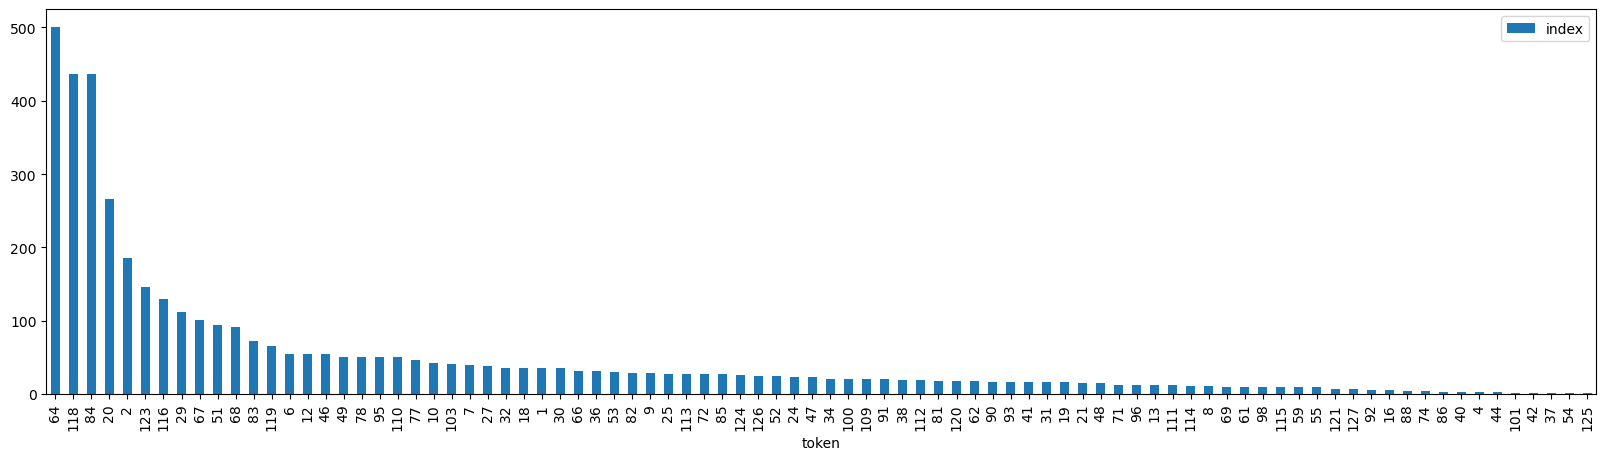

In [187]:
# distribution of the labels tokens
pd.DataFrame([i[1] for i in dataset_actions], columns=["token"]).reset_index().groupby("token").count().reset_index().sort_values(by="index", ascending=False).plot.bar(x="token", y="index", figsize=(20,5))
#pd.DataFrame(Y.numpy().flatten(), columns=["token"]).replace({0:np.nan}).dropna().reset_index().groupby("token").count().reset_index().sort_values(by="index", ascending=False).plot.bar(x="token", y="index", figsize=(20,5))

In [188]:
df_distrib_label = pd.DataFrame([i[1] for i in dataset_actions], columns=['label']).reset_index().groupby('label').count().sort_values(by='index', ascending=False).reset_index()
df_distrib_label

,label,index
0,64,500
1,118,436
2,84,436
3,20,266
4,2,186
...,...,...
81,101,2
82,42,2
83,37,1
84,54,1


We can see actions are not equally present at all. This is why weights are very important. Moreover, there are more than half the actions that are never chosen. 

In [189]:
X.shape, Y.shape

(torch.Size([4201, 15]), torch.Size([4201]))

In [190]:
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256,shuffle=True)

We now have a large amount of different sequences of descent moves. We will train our agent to predict the next move. 

In [191]:
agent.temperature = 1.0
occurences = df_distrib_label.set_index('label').to_dict()['index']
amount_of_apparition = sum(occurences.values())
weights = [amount_of_apparition/occurences[i] if i in occurences else 0 for i in range(len(tokens))]
for i in range(len(weights)):
    if weights[i] == 0:
        weights[i] = max(weights)
weights = [i/sum(weights) for i in weights]

In [192]:
len(weights)

128

In [193]:
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))#, ignore_index=0)
losses = []
roll_scores = []

num_epochs = 300

for epoch in range(num_epochs):
    start = time.time()

    if anneal_lr:
        frac = 1.0 - (epoch / num_epochs)
        optimizer.param_groups[0]['lr'] = learning_rate * frac
        
    total_losses = []

    for X_batch, Y_batch in dataloader:
        optimizer.zero_grad()
        outputs = agent.forward_actor(X_batch.to(device))
        loss = loss_fn(outputs[:,-1,:], Y_batch.to(device))
        #print(loss)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=1.0)
        optimizer.step()
        total_losses.append(loss.item())


    with torch.no_grad():
        if epoch % 10 == 0:
                
            state = torch.tensor(np.zeros(seq_length), device=device, dtype=torch.float32, requires_grad=False).to(device)
            done = False
            step = 0
            environment.reset()
            actions = []
            rewards = []
            
            while not done and step < seq_length:
                state_tensor = state.unsqueeze(0).int()  # Batch dimension
                action = torch.argmax(agent.forward_actor(state_tensor)[:,-1,:][0]).item()
                reward, done = environment.step(action, actions)
                actions.append(action)
                rewards.append(reward)
                # Update state for the next step
                state = torch.cat((state[:step], torch.tensor([action]).to(device), state[step + 1:]))
                step += 1
            score = environment.roll.GetValue()[0] - environment.roll.GetValue()[1]
        end = time.time()

        losses.append(np.mean(total_losses))



    if epoch % 10 == 0:
        print("\n=====================================================================================")
        print(f"Epoch : {epoch}, loss : {losses[-1]:.2f}, roll score : {score}, time : {end-start:.2f}, time left : {(num_epochs-epoch)*(end-start):.2f}")
        print([tokens[i] for i in actions])
        print([i for i in actions])
        print(visualize(environment.roll))
        print("=====================================================================================")
        roll_scores.append(score)
    else:
        print(f"\rEpoch : {epoch}, loss : {losses[-1]:.2f}, time : {end-start:.2f}, time left : {(num_epochs-epoch)*(end-start):.2f}", end = '')


Epoch : 0, loss : 4.85, roll score : 20, time : 0.95, time left : 284.62
[(0, 1), (36, 0), (0, 1), (36, 0), (0, 1), (40, 1), (27, 1), (36, 0), (48, 2), (36, 0), (24, 3), (24, 1), (34, 2), (0, 1), (0, 1)]
[20, 64, 20, 64, 20, 118, 1, 64, 84, 64, 110, 53, 2, 20, 20]
1 1 1 1 1 1 1 1 | -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 1 1 1 1 1 1 1 1 | -- 0 0 0 0 | 1 1 1 1 1 1 1 1 | 2 2 | 
Epoch : 9, loss : 4.85, time : 0.52, time left : 151.32
Epoch : 10, loss : 4.85, roll score : -43, time : 0.65, time left : 187.12
[(36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0), (36, 0)]
[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 0 0 0 0 | -- -- -- -- -- -- -- -- -- -- 
Epoch : 19, loss : 4.85, time : 0.55, time left : 153.92
Epoch : 20, loss : 4.85, roll score : -20, time : 0.63, time left : 1

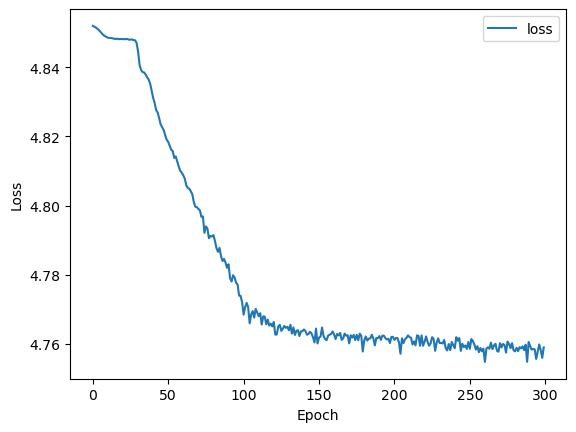

In [194]:
# plot the losses

plt.plot(losses)
plt.legend(['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

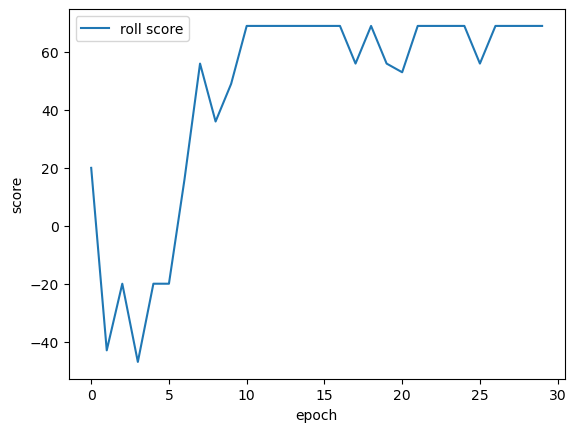

In [195]:
# plot the scores

plt.plot(roll_scores)
plt.legend(['roll score'])
plt.xlabel('epoch')
plt.ylabel('score')
plt.show()

#### Test

In [196]:
state = torch.tensor(np.zeros(seq_length), device=device, dtype=torch.float32, requires_grad=False)
done = False
step = 0
environment.reset()
actions = []
rewards = []
with torch.no_grad():
    while not done and step < seq_length:
        state_tensor = state.unsqueeze(0).int()  # Batch dimension
        action = torch.argmax(agent.forward_actor(state_tensor)[:,-1,:][0]).item()
        reward, done = environment.step(action, actions)
        actions.append(action)
        rewards.append(reward)
        # Update state for the next step
        state = torch.cat((state[:step], torch.tensor([action]).to(device), state[step + 1:]))
        step += 1

environment.roll.GetValue()

(69, 0)

In [197]:
print(actions)

for i in actions:
    print(tokens[i], end = ' ')


print('\n', visualize(environment.roll))

[20, 123, 67, 51, 29, 2, 64, 118, 84]
(0, 1) (8, 1) (16, 3) (21, 1) (29, 3) (34, 2) (36, 0) (40, 1) (48, 2) 
 1 1 1 1 1 1 1 1 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 1 1 1 1 1 1 1 1 | 3 3 3 3 3 | 2 2 | 0 0 0 0 | 1 1 1 1 1 1 1 1 | 2 2 | 


With this technique we can find optimum even with less good elements than maximum in the initial population which is promising for bigger roll.

This result is achieved in 300 epochs which is not a lot and is about 3mins long.

### Method 2 - Reinforcement Learning with Proximal Policy Optimization

Here we will use encoder to have a meaningful representations of each sequences. We use encoder to let the model focus on representation and to not be bothered by the length of the sequences who are changing along each episodes. This seemed more appropriate for the problem to not have predetermined length of sequences to let the model focus on important part of the sequence. Thanks to this the model does not have to learn when a sequence is ended. 

To train this model we will use PPO, a reinforcement learning technique.

Proximal Policy Optimization (PPO) is an architecture that improves the agent's training stability by avoiding too large policy updates. To do that, we use a ration that will indicates the difference between our current policy and clip this ration from a specific range. 

Doing this will ensure that our policy update is not too large and that the training is more stable. 

For more detail you can check the course who inspired us from hugging face by clicking <a href = "https://huggingface.co/blog/deep-rl-ppo">this link</a>.

The actor critic methods used is a hybrid architecture combining value-based adnd policy based methods that helps to stabilize the training by using: 

- An agent that controls our agent behaviors (Policy-based method)
- A critic that measures how good the take action is (Value-based method)

The agent will learn from the feedback of the critic and the critic will also give better and better feedback across epochs. 

Here is the actor critic process shown in this <a href = "https://huggingface.co/learn/deep-rl-course/unit6/advantage-actor-critic">hugging face course</a>

At each timestep, t, we get the current state $S_t$ from the environment and pass it as input through our $Actor$ and $Critic$.
Our Policy takes the state and outputs an action $A_t$

<img src = "step1.jpg" width = 700/>

The critic takes that action also as input, and using $S_t$ and $A_t$, computes the value of taking that action at that state: the **Q-values**

<img src = "step2.jpg" width = 700/>

Action $A_t$ is performed in the environment and gives a new state $S_t+1$ and a reward $R_t+1$

<img src = "step3.jpg" width = 700/>

The $Actor$ updates its policy using Q-Value 

<img src = "step4.jpg" width = 700/>

Thanks to its updated parameters, the $Actor$ produces the next action to take $A_t+1$ given the new state $S_t+1$. 

The critic then updates its value parameters.

<img src = "step5.jpg" width = 700/>



In [207]:
class AttentionPooling(nn.Module):
    def __init__(self, embedding_dim):
        super(AttentionPooling, self).__init__()
        self.attention_weights = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        # Compute attention scores
        scores = self.attention_weights(x).squeeze(-1)  # (batch_size, seq_len)
        attention_weights = torch.softmax(scores, dim=-1)  # Normalize scores
        # Weighted sum of token representations
        context_vector = torch.sum(x * attention_weights.unsqueeze(-1), dim=1)
        return context_vector
  
class TransformerAgent_RL(nn.Module):
    def __init__(self, seq_length: int, n_tokens:int, nhead: int = 8, num_layers: int = 1, embedding_dim: int = 64, temperature = 1.0, dropout: float = 0.01):
        super(TransformerAgent_RL, self).__init__()


        self.attention_pooling = AttentionPooling(embedding_dim)

        # Feature embedding layers to reduce input dimensions
        '''
        self.token_embedding = nn.Sequential(
            layer_init(nn.Linear(seq_length, 1024)),
            nn.ReLU(),
            layer_init(nn.Linear(1024, 1024)),
            nn.ReLU(),
            layer_init(nn.Linear(1024, 512)),
            nn.ReLU()
        )
        '''
        self.temperature = temperature
        self.dropout_rate = dropout

        self.token_embedding = nn.Embedding(num_embeddings=n_tokens, embedding_dim=embedding_dim) # embedding_dim chosen by the rule of thumb 
        
        # Positional encoding for sequence order
        self.positional_encoding = PositionalEncoding(embedding_dim=embedding_dim, max_len=seq_length)
        
        # Transformer layer
        transformer_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, batch_first=True, dim_feedforward=4*embedding_dim, dropout=self.dropout_rate) # maybe modifying dim_forward by 4*64
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers) # maybe increasing the number of layers to 4-6
        
        # Separate heads for actor (position and ID) and critic
        self.actor = nn.Sequential(
            layer_init(nn.Linear(embedding_dim, embedding_dim*4)),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            layer_init(nn.Linear(embedding_dim*4, embedding_dim*2)),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            layer_init(nn.Linear(embedding_dim*2, n_tokens), std=0.01),  
            nn.Softmax(dim=-1)            
        )

        self.critic = nn.Sequential( 
            layer_init(nn.Linear(embedding_dim, 4*embedding_dim)),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            layer_init(nn.Linear(4*embedding_dim, 2*embedding_dim)),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            layer_init(nn.Linear(2*embedding_dim, 1), std=1.0)
        )

    def update_temp(self, new_temp):
        self.temperature = new_temp


    def evaluate_actions(self, states, actions):
        token_probs = self.forward_actor(states)
        token_dist = Categorical(token_probs)
        log_probs = token_dist.log_prob(actions)
        entropy = token_dist.entropy()
        values = self.forward_critics(states)
        return log_probs, entropy, values
        
    def forward_critics(self, x):
        # Run critic-specific forward pass
        x = self.token_embedding(x)
        x = self.positional_encoding(x)
        
        x = self.transformer(x)
        #x = x.mean(dim=1)  # Aggregate over sequence (mean-pooling)
        x = self.attention_pooling(x) # we use attention pooling over mean-pooling because it offers better performances, as it is another learnable parameters which will aggregate over sequence in a better way than just the mean even if it makes the model longer to converge.

        return self.critic(x)
    

    def forward_actor(self, x):
        # Run actor-specific forward pass
        x = self.token_embedding(x)  # Convert token IDs to embeddings
        x = self.positional_encoding(x)  # Add positional encoding
        
        x = self.transformer(x)

        #x = x.mean(dim=1)  # Aggregate over sequence for final action prediction
        x = self.attention_pooling(x)
        
        y = self.actor(x)


        return y/self.temperature


    def select_action(self, state: torch.tensor) -> tuple[int, int, torch.tensor, torch.tensor]:
        # Select action from the current state
        token_prob = self.forward_actor(state)
        token_dist = Categorical(token_prob)
        token = token_dist.sample()
        token_log_prob = token_dist.log_prob(token)
        
        return token.item(), token_log_prob, token_dist.entropy(), self.forward_critics(state)

In [208]:
len_roll = 20 # the length of the roll
baby_defects = {key:defects[key] for key in defects.keys() if key < len_roll}
baby_roll = Roll(len_roll, baby_defects)

In [209]:
possible = PossibleState(baby_roll, ([biscuit0, biscuit1, biscuit2, biscuit3]))

tokens = [(-1,-1)] # padding token
for i in possible:
    for key in i.biscuits.keys():
        tokens.append((key, i.biscuits[key].id))


In [210]:
seq_length = 15 # 100 because never exceed this amount in pratice #int(baby_roll.length/2)  # max length of seqeunce of action

# Initialize agent and environment
dropout_rate = 0.0
n_tokens = len(tokens)  # total tokens (positions x biscuit types)
embedding_dim = 32  # embedding dimension chosen by the rule of thumb, 32 for a roll of length 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_layers = 6 #6
n_heads = 8 #8

anneal_lr = True

learning_rate = 1e-4

temperature = 1.0

In [211]:
gamma = 0.99
lambda_gae = 0.95
clip_epsilon = 0.2
entropy_coeff = 0.01
critic_coeff = 0.5
learning_rate = 1e-4
update_epochs = 4
max_steps_per_episode = seq_length
num_epochs = 2500

min_temp = 1.0
temperature = 1.0

anneal_temp = False

alpha = abs(min_temp - temperature)/num_epochs

environment = TransformerEnvironment(roll=baby_roll, biscuits=[biscuit0, biscuit1, biscuit2, biscuit3], tokens=tokens)
agent = TransformerAgent_RL(seq_length, len(tokens), nhead=n_heads, num_layers=num_layers, embedding_dim=embedding_dim, temperature=temperature, dropout=0.0).to(device)

eps = 1e-5
optimizer = optim.Adam(agent.parameters(), lr=learning_rate, eps=eps)

In [212]:
roll_scores = []
set_bests = set()

amount_well_placed = []
rewards_per_epoch = []
entropies_per_epoch = [] # mean entropy per epoch
advantages_per_epoch = [] # mean advantage per epoch
episode_length = []

all_actions = {i:0 for i in range(n_tokens)}

policy_losses = []
value_losses = []
total_losses = []

Generalized Advantage Estimation (GAE) is a technique used to improve the estimation of the advantage function, which measures how good an action is compared to the baseline (usually the value function). It was introduced in Proximal Policy Optimization (PPO) and is widely used because it balances bias and variance in advantage estimation. We use it in PPO because accurate advantage estimates are critical for effective updates.

In [213]:
# GAE computation
def compute_gae(rewards, values, dones, gamma, lambda_gae):
    advantages = []
    returns = []
    gae = 0
    next_value = 0
    for t in reversed(range(len(rewards))):
        mask = 1 - dones[t]
        delta = rewards[t] + gamma * next_value * mask - values[t]
        gae = delta + gamma * lambda_gae * mask * gae
        advantages.insert(0, gae)
        returns.insert(0, gae + values[t])
        next_value = values[t]
    return torch.tensor(returns), torch.tensor(advantages)

In [214]:
# PPO training loop
best_roll = baby_roll

for epoch in range(num_epochs):  # number of training epochs
    states, actions, rewards, log_probs, values, dones = [], [], [], [], [], []
    state = torch.tensor(np.zeros(max_steps_per_episode), device=device, dtype=torch.float32, requires_grad=False)
    done = False
    step = 0
    environment.reset()

    # Learning rate annealing
    if anneal_lr:
        frac = 1.0 - (epoch / num_epochs)
        optimizer.param_groups[0]['lr'] = learning_rate * frac

    # Temperature annealing
    if anneal_temp:
        temperature = temperature - alpha
        agent.update_temp(temperature)

    # Rollout collection
    while not done and step < max_steps_per_episode:
        state_tensor = state.unsqueeze(0).int()  # Batch dimension
        state_tensor = state_tensor.to(device)
        action, log_prob, entropy, value = agent.select_action(state_tensor)

        all_actions[action] += 1

        actions.append(action)
        
        reward, done = environment.step(action, actions)

        # Store trajectory (detach tensors to prevent retaining computation graph)
        states.append(state_tensor.detach())
        
        rewards.append(reward)
        log_probs.append(log_prob.detach())
        values.append(value.detach())
        dones.append(done)

        # Update state for the next step
        state = torch.cat((state[:step], torch.tensor([action]).to(device), state[step + 1:]))
        step += 1
    

    amount_well_placed.append(len([i for i in rewards if i > 0]))
    episode_length.append(step)
    

    roll_scores.append(environment.roll.GetValue()[0] - environment.roll.GetValue()[1])

    if roll_scores[-1] == max(roll_scores):
        if roll_scores[-1] > best_roll.GetValue()[0] - best_roll.GetValue()[1]:
            set_bests = set()
        best_roll = environment.roll
        set_bests.add(best_roll)
        
        #torch.save(agent.state_dict(), f"best_agent.pth")

    # Compute advantages and returns
    returns, advantages = compute_gae(rewards, values, dones, gamma, lambda_gae)
    returns = returns.to(device)
    advantages = advantages.to(device)
    
    states = torch.cat(states)
    actions = torch.tensor(actions, device=device)
    log_probs = torch.cat(log_probs)
    values = torch.tensor(values, device=device)
    
    # PPO update
    for _ in range(update_epochs):
        # Recompute forward pass for updated log_probs, entropy, and values
        log_probs_new, entropy, values_new = agent.evaluate_actions(states, actions)

        # Ratio for PPO loss
        ratio = torch.exp(log_probs_new - log_probs).to(device)

        # Clipped surrogate objective
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()

        # Value function loss
        value_loss = ((returns - values_new) ** 2).mean()

        # Entropy regularization
        entropy_loss = -entropy.mean()

        # Total loss
        loss = policy_loss + critic_coeff * value_loss + entropy_coeff * entropy_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Logging
    total_reward = sum(rewards)
    rewards_per_epoch.append(total_reward)
    entropies_per_epoch.append(entropy.mean().item())
    advantages_per_epoch.append(advantages)
    policy_losses.append(policy_loss.item())
    value_losses.append(value_loss.item())
    total_losses.append(loss.item())
    print(f"Epoch {epoch}: Total Reward = {total_reward:.2f}, Loss = {loss.item():.4f}, roll score = {roll_scores[-1]}, temperature = {agent.temperature:.2f}")

Epoch 0: Total Reward = -26.00, Loss = 124.4554, roll score = -4, temperature = 1.00
Epoch 1: Total Reward = -119.00, Loss = 1616.7231, roll score = 6, temperature = 1.00
Epoch 2: Total Reward = -27.00, Loss = 190.9942, roll score = 10, temperature = 1.00
Epoch 3: Total Reward = -90.00, Loss = 1406.2473, roll score = 7, temperature = 1.00
Epoch 4: Total Reward = -23.00, Loss = 114.6682, roll score = 3, temperature = 1.00
Epoch 5: Total Reward = -26.00, Loss = 98.5473, roll score = 0, temperature = 1.00
Epoch 6: Total Reward = -129.00, Loss = 3051.2917, roll score = 7, temperature = 1.00
Epoch 7: Total Reward = -60.00, Loss = 562.5503, roll score = 7, temperature = 1.00
Epoch 8: Total Reward = -25.00, Loss = 98.8473, roll score = -4, temperature = 1.00
Epoch 9: Total Reward = -68.00, Loss = 1490.9332, roll score = 23, temperature = 1.00
Epoch 10: Total Reward = -115.00, Loss = 2555.6711, roll score = 0, temperature = 1.00
Epoch 11: Total Reward = -39.00, Loss = 294.0885, roll score = 3,

#### Testing of the agent

In [222]:
state = torch.tensor(np.zeros(max_steps_per_episode), device=device, dtype=torch.float32, requires_grad=False)
done = False
step = 0
environment.reset()
actions = []
rewards = []

with torch.no_grad():

    while not done and step < max_steps_per_episode:
        state_tensor = state.unsqueeze(0).int()  # Batch dimension
        action, log_prob, entropy, value = agent.select_action(state_tensor)
        reward, done = environment.step(action, actions)
        actions.append(action)
        rewards.append(reward)
        # Update state for the next step
        state = torch.cat((state[:step], torch.tensor([action]).to(device), state[step + 1:]))
        step += 1

environment.roll.GetValue()

(24, 4)

#### Visualization of training process

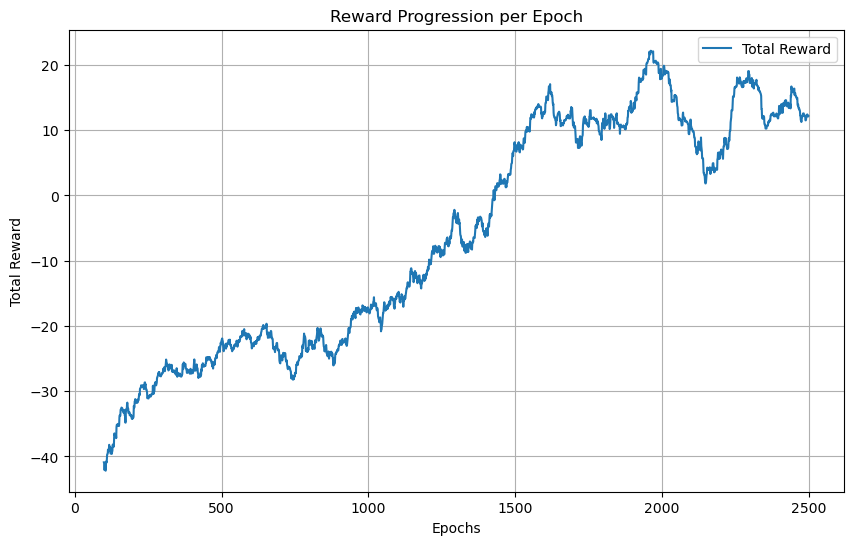

In [216]:
epochs = list(range(num_epochs))
total_rewards = rewards_per_epoch

plt.figure(figsize=(10, 6))
plt.plot(epochs, pd.Series(total_rewards).rolling(100).mean(), label='Total Reward')
plt.xlabel('Epochs')
plt.ylabel('Total Reward')
plt.title('Reward Progression per Epoch')
plt.legend()
plt.grid()
plt.show()

We can see the agent found a stable policy after 600 epochs. 

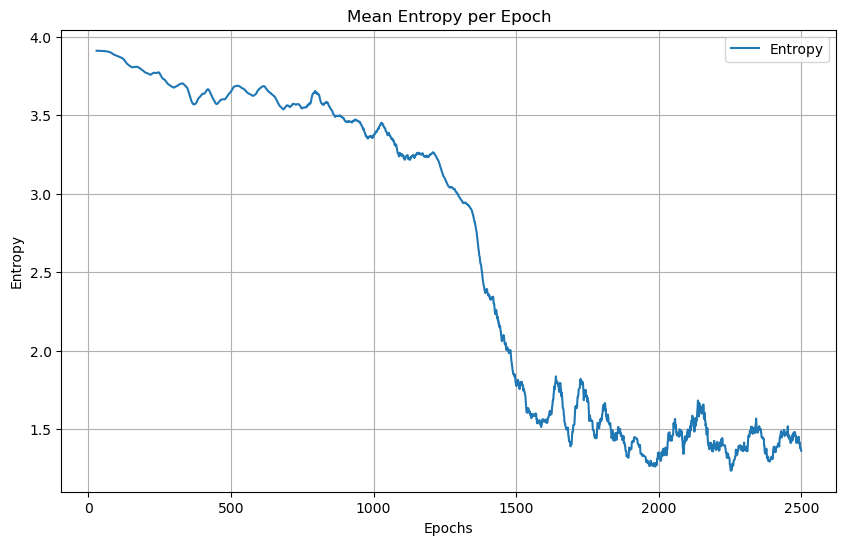

In [217]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, pd.Series(entropies_per_epoch).rolling(30).mean(), label='Entropy')  # mean entropy per epoch
plt.xlabel('Epochs')
plt.ylabel('Entropy')
plt.title('Mean Entropy per Epoch')
plt.legend()
plt.grid() 
plt.show()

How the entropy of the policy changes. High entropy indicates exploration, while low entropy shows exploitation. We can see the entropy is very low after 600 epochs that means the agent not explore a lot after 600 epochs.

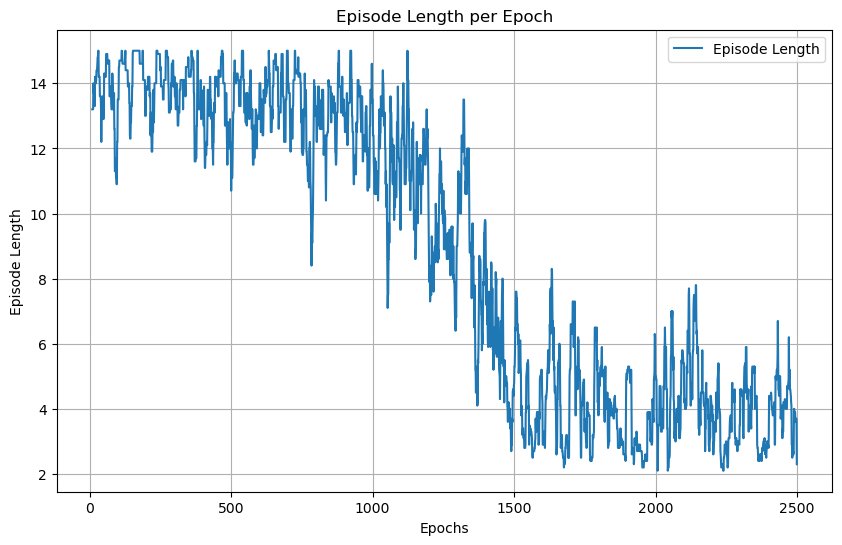

In [218]:
# rolling mean on episode length

plt.figure(figsize=(10, 6))
plt.plot(epochs, pd.Series(episode_length).rolling(10).mean(), label='Episode Length')
plt.xlabel('Epochs')
plt.ylabel('Episode Length')
plt.title('Episode Length per Epoch')
plt.legend()
plt.grid()

We can see that episodes are shorter and shorter, so the agent learns how to place correctly the biscuits. 

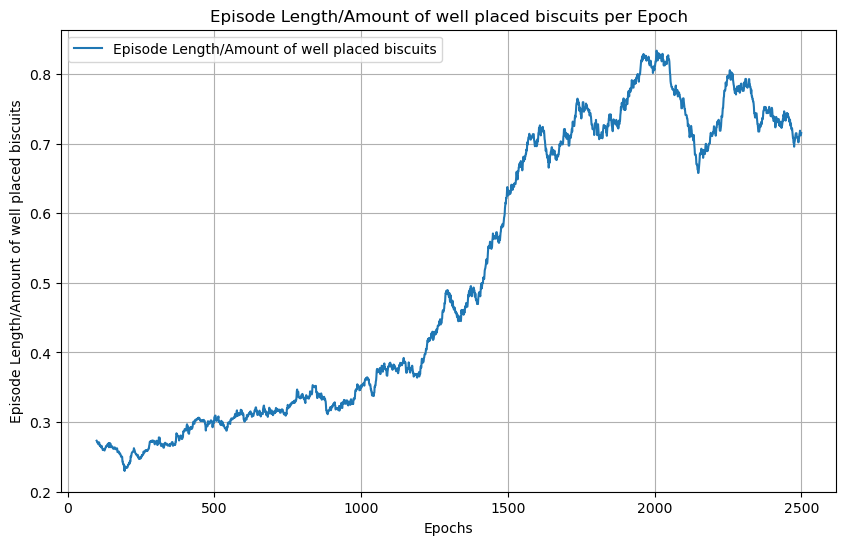

In [219]:
# rolling mean on episode length/amount of well placed biscuits
ep_length_arr = np.array(episode_length)
well_placed_arr = np.array(amount_well_placed)

plt.figure(figsize=(10, 6))
plt.plot(epochs, pd.Series(well_placed_arr/ep_length_arr).rolling(100).mean(), label='Episode Length/Amount of well placed biscuits')
plt.xlabel('Epochs')
plt.ylabel('Episode Length/Amount of well placed biscuits')
plt.title('Episode Length/Amount of well placed biscuits per Epoch')
plt.legend()
plt.grid()
plt.show()

We can see it almosts not misplaced biscuits at the end.

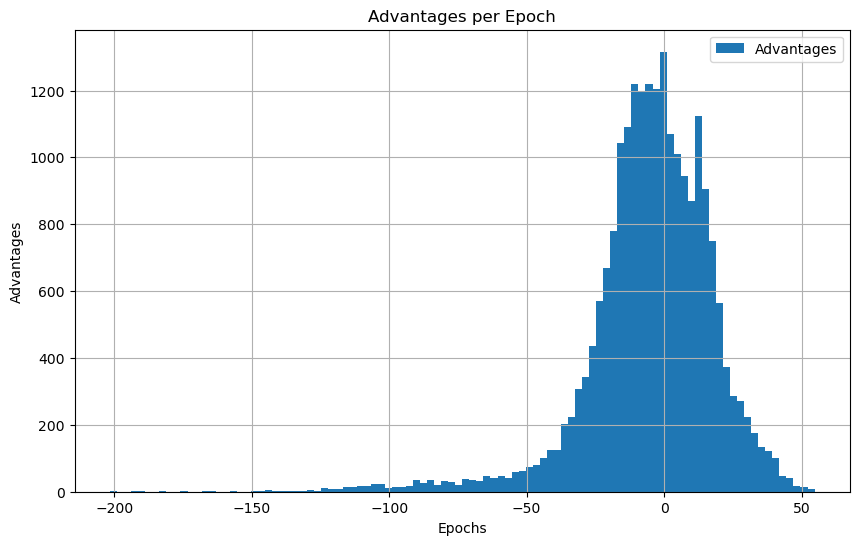

In [220]:
# distribution of the advantages

plt.figure(figsize=(10, 6))
plt.hist(torch.cat(advantages_per_epoch).cpu().numpy(), label='Advantages', bins= 100)
plt.xlabel('Epochs')
plt.ylabel('Advantages')
plt.title('Advantages per Epoch')
plt.legend()
plt.grid()
plt.show()

We can see that despite some outliers the advantages are well distributed. That means the critics learned well.

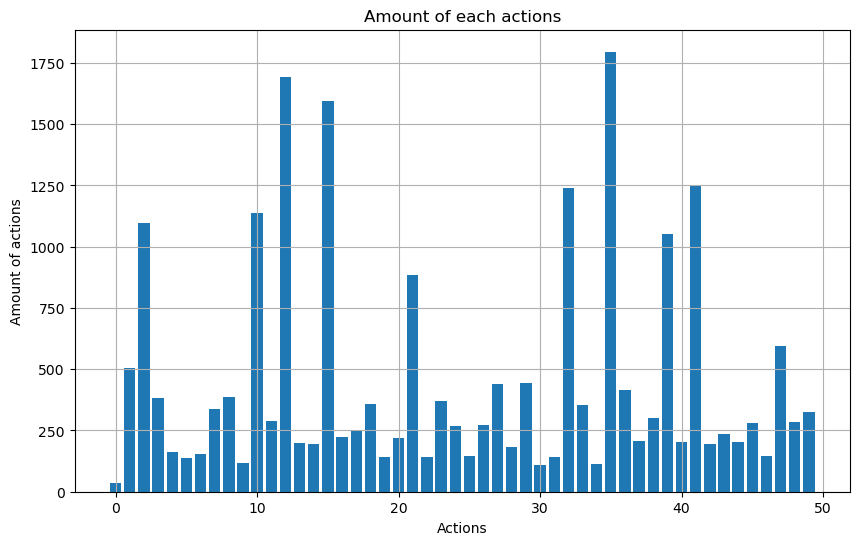

In [221]:
pd.DataFrame(all_actions, index = [0]).T

# distribution of the actions

plt.figure(figsize=(10, 6))
plt.bar(all_actions.keys(), all_actions.values())
plt.xlabel('Actions')
plt.ylabel('Amount of actions')
plt.title('Amount of each actions')
plt.grid()
plt.show()

We can see the model develop preferences of choosing actions more than others.

We can see this model can learn but it is longer than for the first method (2500 epochs here and more than 15 mins). This method does not find the optimal for a roll of length 20. The first method offers way better results in less time. The advantage of this method is that it does not require initial data.

## Conclusion

These approaches does not have the same results. The first method offers promising results on longer roll by finding the optimum in few epochs on roll of length 50. The second one struggles to find good results on a roll of length 20. So, even if we can see the both approaches seem to learn effectively the first one is way better than the second. However, the second one has the advantage to not requiring initial data. 

To upgrade this approach we could find better hyperparameters for better convergence even if the modifications should be limited. It may exist other architectures that could be better to solve this problem. It is even possible that other formalization could lead to better results. 

Like keeping the roll as it is (biscuit and empty spaces) and processing it like an image. As images are matrix, a roll could be a $2 \times (500 \times n)$ matrix where $n$ would be the maximum amount of defects per units and 2 to have one line for the biscuit placed and one line for the defects.

 Processing this with convolutional layers could be an other approach. The convolutional layers would extract features from the roll and with these features the model would make a prediction of the biscuit to place.

# Discussion and Conclusion

During this project we have seen several optimization algorithm like greedy algorithms, genetics, local search and some deep learning. We obtained the best results with the genetic algorithm. It offers good results but takes time to give excellent results, is hard to parametrized and need good initial population. At the opposite, the greedy algorithms does not need initial solution to be good and are very fast to compute. Moreover, they offer descent results. A compromise between these two techniques could be the local search algorithms which give better results than the greedys, compute way faster than the genetics and are easy to parametrize. Even if the hill climbing and stochastic hill climbing ascent needs strong initialization this is not the case of the simulated annealing technique which offers strong results despite poor initialization.

Deep learning techniques used are probably not the best for this problem. The both techniques tested showed promising results on little rolls but asks lots of parametrization, computational ressources and strong initialization for the semi-supervised method. 

To conclude, the methods we think are the best to adress this problem are the genetic algorithm and simulated annealing. As we can easily create great amount of good individuals, we can provide enough diversity for the genetic algorithm to generate good solutions. However, the ability of simulated annealing to produce good solutions from scratch is above that of all the others, making it a correct choice.